# Compare surface topography

Author: Ziqi Yin

Last modified: 2025 Jan 23

Table of contents:
* [Maps of annual mean surface topography difference (CAM)](#first-bullet)
* [Hypsometric surface elevation-area relationships (CAM)](#second-bullet)
* [Hypsometric surface elevation-area relationships (CISM+CAM)](#third-bullet)

In [2]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
from math import radians, sin, cos, sqrt, atan2

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
import cartopy.feature as cfeature
import geocat.comp as gc #to interpolate and extrapolate data from hybrid-sigma levels to isobaric levels

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
#import xesmf as xe

In [3]:
## Parameter
g = 9.80616 #[m/s2]

## 1. Topography difference (CAM) <a class="anchor" id="first-bullet"></a>

### Read data

In [3]:
## f09nohacks
# piControl
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']
f09_lon = f09_nohacks_piControl_PHIS_JJA_yearly.lon
f09_lat = f09_nohacks_piControl_PHIS_JJA_yearly.lat

In [4]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']
ARCTIC_ncol = ARCTIC_piControl_p4_PHIS_JJA_yearly.ncol

### Calculate

In [5]:
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_nohacks_PHIS_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-1,:]

In [6]:
# Save as netcdf file
df = xr.DataArray(f09_nohacks_PHIS_PI.values, dims=['lat','lon'], coords=[('lat', f09_lat.values),('lon', f09_lon.values)], name='PHIS', attrs=dict(longname='Surface geopotential at the last year of piControl', units='m2/s2'))
df.to_netcdf(home_dir+'dynamic_GrIS/github/data/processed/F09_piControl_PHIS_yearly_lastyear.nc')

df = xr.DataArray(ARCTIC_PHIS_PI.values, dims=['ncol'], coords=[('ncol', ARCTIC_ncol.values)], name='PHIS', attrs=dict(longname='Surface geopotential at the last year of piControl', units='m2/s2'))
df.to_netcdf(home_dir+'dynamic_GrIS/github/data/processed/ARCTIC_piControl_p4_PHIS_yearly_lastyear.nc')

In [7]:
# Reread the saved data
f09_nohacks_PHIS_PI = xr.open_dataset(home_dir+'dynamic_GrIS/github/data/processed/F09_piControl_PHIS_yearly_lastyear.nc')['PHIS']
ARCTIC_PHIS_PI = xr.open_dataset(home_dir+'dynamic_GrIS/github/data/processed/ARCTIC_piControl_p4_PHIS_yearly_lastyear.nc')['PHIS']

### Prepare for plotting SE grids

In [8]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [9]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.

    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)

    return var, verts

In [10]:
ARCTIC_PHIS_PI_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_PI)[0]
ARCTIC_PHIS_PI_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_PHIS_PI)[1]

In [11]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

### Regrid ARCTIC to f09

In [12]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [13]:
ESMF.Manager(debug=True);

In [14]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [16]:
ARCTIC2f09_PHIS_PI = f09_nohacks_PHIS_PI * 0

ARCTIC2f09_PHIS_PI[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_PHIS_PI, f09_centers, f09_corners)

In [17]:
## Calculate difference
ARCTIC_f09_nohacks_PHIS_diff_PI = ARCTIC2f09_PHIS_PI - f09_nohacks_PHIS_PI

In [18]:
## Max and min values
print(ARCTIC_f09_nohacks_PHIS_diff_PI.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).max().values/g)
print(ARCTIC_f09_nohacks_PHIS_diff_PI.sel(lat=slice(58,84)).sel(lon=slice(-56+360,-30+360)).min().values/g)
print('')

729.6111417466163
-544.338568180613



### Plot

In [17]:
## Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

In [18]:
## Add cyclic point
f09_nohacks_PHIS_PI2, f09_lon2 = add_cyclic_point(f09_nohacks_PHIS_PI, coord=f09_lon)

f09_PHIS_PI2, f09_lon2 = add_cyclic_point(f09_PHIS_PI[:,:], coord=f09_lon)

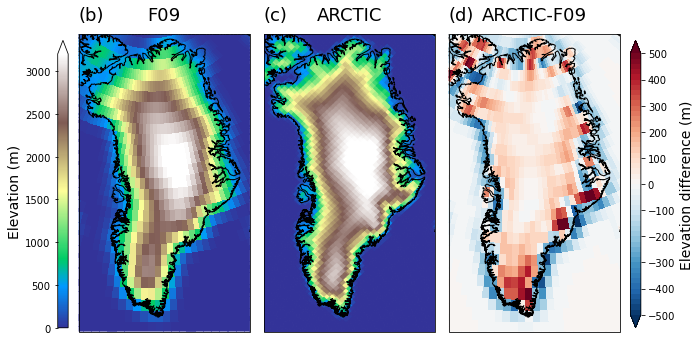

In [23]:
fig = plt.figure(figsize = (9.7,6.2))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

cmap = plt.cm.terrain

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-500.,500.1,20.)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-500.,500.1,100.)

#---------------------------------------------elev----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon2, f09_lat, f09_nohacks_PHIS_PI2/g, transform = crs_ll, cmap=cmap, vmin=0, vmax=3200)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(b)', fontsize=18, loc='left')
plt.title('F09', fontsize=18, loc='center')

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.4, -29.6, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_PHIS_PI_verts, cmap=cmap, transform=crs_ll,
                     **kwd_polycollection)
im2.set_array(ARCTIC_PHIS_PI_var/g)
im2.set_clim(vmin=0, vmax=3200)
ax2.add_collection(im2)
plt.title('(c)', fontsize=18, loc='left')
plt.title('ARCTIC', fontsize=18, loc='center')

# colorbar
cbar_ax2 = fig.add_axes([0.095, 0.178, 0.015, 0.644])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', extend='max')
cb2.set_label(label='Elevation (m)', size=14)
cb2.ax.tick_params(labelsize=10)
cb2.ax.yaxis.set_ticks_position('left')
cb2.ax.yaxis.set_label_position('left')

#---------------------------------------------diff----------------------------------------------------
ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, ARCTIC_f09_nohacks_PHIS_diff_PI/g, transform=crs_ll, cmap=cmap2, norm=norm2)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(d)', fontsize=18, loc='left')
plt.title('ARCTIC-F09', fontsize=18, loc='center')

# colorbar
cbar_ax3 = fig.add_axes([0.915, 0.178, 0.015, 0.644])
cb3 = fig.colorbar(im3, cax=cbar_ax3, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb3.set_label(label='Elevation difference (m)', size=14)
cb3.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.08,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_elev_elev_diff_PI.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 2. Hypsometric surface elevation-area relationship (CAM) <a class="anchor" id="second-bullet"></a>

### 2.1 The whole ice sheet

#### Read data

In [4]:
## BG iteration 7
BG7_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PHIS_JJA_yearly.nc')['PHIS'] #surface geopotential [m2/s2]
f09_lon = BG7_PHIS_JJA_yearly.lon
f09_lat = BG7_PHIS_JJA_yearly.lat

In [5]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140,:,:]

# 4xext
f09_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [6]:
## f09nohacks
# piControl
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']

# 1pctCO2
f09_nohacks_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
f09_nohacks_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [7]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']

# 1pctCO2
ARCTIC_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
ARCTIC_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [8]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_1pctCO2_PHIS_JJA_yearly, f09_4xext_PHIS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_JJA_yearly, f09_nohacks_4xext_PHIS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_JJA_yearly, ARCTIC_4xext_PHIS_JJA_yearly], dim='time')

In [9]:
# Scrip files (contains grid information)
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [10]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2
f09_ones = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[0,:,:] * 0 + 1
f09_area_coord = f09_ones * f09_area # grid area with lon,lat coordinates

f09_mask_file2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file2)['landfrac'] #fraction of grid cell that is active

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2
ARCTIC_ones = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[0,:] * 0 + 1
ARCTIC_area_coord = ARCTIC_ones * ARCTIC_area.squeeze() # grid area with lon,lat coordinates

ARCTIC_mask_file2 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file2)['landfrac']

In [11]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_land_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/F09/F09_landfrac.nc')['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_land_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/ARCTIC/ARCTIC_landfrac.nc')['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

#### Calculate

In [12]:
## Select PHIS (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_PHIS_mask_PI = BG7_PHIS_JJA_yearly[148,:,:].where(BG7_GrIS_mask[148,:,:]>0)
f09_nohacks_PHIS_mask_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-1,:,:].where(f09_nohacks_GrIS_mask_piControl[-1,:,:]>0)
ARCTIC_PHIS_mask_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-1,:].where(ARCTIC_GrIS_mask_piControl[-1,:]>0)

# CO2 stabilization (year 150)
f09_PHIS_mask_stab = f09_1pctCO2_4xext_PHIS_JJA_yearly[149,:,:].where(f09_GrIS_mask[149,:,:]>0)
f09_nohacks_PHIS_mask_stab = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[149,:,:].where(f09_nohacks_GrIS_mask[149,:,:]>0)
ARCTIC_PHIS_mask_stab = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[149,:].where(ARCTIC_GrIS_mask[149,:]>0)

# Middle (year 250)
f09_PHIS_mask_mid = f09_1pctCO2_4xext_PHIS_JJA_yearly[249,:,:].where(f09_GrIS_mask[249,:,:]>0)
f09_nohacks_PHIS_mask_mid = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[249,:,:].where(f09_nohacks_GrIS_mask[249,:,:]>0)
ARCTIC_PHIS_mask_mid = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[249,:].where(ARCTIC_GrIS_mask[249,:]>0)

# end of simulation (year 350)
f09_PHIS_mask_end = f09_4xext_PHIS_JJA_yearly[-1,:,:].where(f09_GrIS_mask[-1,:,:]>0)
f09_nohacks_PHIS_mask_end = f09_nohacks_4xext_PHIS_JJA_yearly[-1,:,:].where(f09_nohacks_GrIS_mask[-1,:,:]>0)
ARCTIC_PHIS_mask_end = ARCTIC_4xext_PHIS_JJA_yearly[-1,:].where(ARCTIC_GrIS_mask[-1,:]>0)

In [13]:
## Select area (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_area_mask_PI = BG7_GrIS_mask[148,:,:] * f09_area_coord.where(BG7_GrIS_mask[148,:,:]>0)
f09_nohacks_area_mask_PI = f09_nohacks_GrIS_mask_piControl[-1,:,:] * f09_area_coord.where(f09_nohacks_GrIS_mask_piControl[-1,:,:]>0)
ARCTIC_area_mask_PI = ARCTIC_GrIS_mask_piControl[-1,:] * ARCTIC_area_coord.where(ARCTIC_GrIS_mask_piControl[-1,:]>0)

# CO2 stabilization (year 150)
f09_area_mask_stab = f09_GrIS_mask[149,:,:] * f09_area_coord.where(f09_GrIS_mask[149,:,:]>0)
f09_nohacks_area_mask_stab = f09_nohacks_GrIS_mask[149,:,:] * f09_area_coord.where(f09_nohacks_GrIS_mask[149,:,:]>0)
ARCTIC_area_mask_stab = ARCTIC_GrIS_mask[149,:] * ARCTIC_area_coord.where(ARCTIC_GrIS_mask[149,:]>0)

# CO2 stabilization (year 250)
f09_area_mask_mid = f09_GrIS_mask[249,:,:] * f09_area_coord.where(f09_GrIS_mask[249,:,:]>0)
f09_nohacks_area_mask_mid = f09_nohacks_GrIS_mask[249,:,:] * f09_area_coord.where(f09_nohacks_GrIS_mask[249,:,:]>0)
ARCTIC_area_mask_mid = ARCTIC_GrIS_mask[249,:] * ARCTIC_area_coord.where(ARCTIC_GrIS_mask[249,:]>0)

# end of simulation (year 350)
f09_area_mask_end = f09_GrIS_mask[-1,:,:] * f09_area_coord.where(f09_GrIS_mask[-1,:,:]>0)
f09_nohacks_area_mask_end = f09_nohacks_GrIS_mask[-1,:,:] * f09_area_coord.where(f09_nohacks_GrIS_mask[-1,:,:]>0)
ARCTIC_area_mask_end = ARCTIC_GrIS_mask[-1,:] * ARCTIC_area_coord.where(ARCTIC_GrIS_mask[-1,:]>0)

In [14]:
## Drop NAN values
# F09M
f09_elev_PI = f09_PHIS_mask_PI.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI = f09_area_mask_PI.stack(p=('lat','lon')).dropna(dim='p')

f09_elev_stab = f09_PHIS_mask_stab.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_stab = f09_area_mask_stab.stack(p=('lat','lon')).dropna(dim='p')

f09_elev_mid = f09_PHIS_mask_mid.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_mid = f09_area_mask_mid.stack(p=('lat','lon')).dropna(dim='p')

f09_elev_end = f09_PHIS_mask_end.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end = f09_area_mask_end.stack(p=('lat','lon')).dropna(dim='p')

# F09
f09_nohacks_elev_PI = f09_nohacks_PHIS_mask_PI.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI = f09_nohacks_area_mask_PI.stack(p=('lat','lon')).dropna(dim='p')

f09_nohacks_elev_stab = f09_nohacks_PHIS_mask_stab.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_stab = f09_nohacks_area_mask_stab.stack(p=('lat','lon')).dropna(dim='p')

f09_nohacks_elev_mid = f09_nohacks_PHIS_mask_mid.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_mid = f09_nohacks_area_mask_mid.stack(p=('lat','lon')).dropna(dim='p')

f09_nohacks_elev_end = f09_nohacks_PHIS_mask_end.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end = f09_nohacks_area_mask_end.stack(p=('lat','lon')).dropna(dim='p')

# ARCTIC
ARCTIC_elev_PI = ARCTIC_PHIS_mask_PI.dropna(dim='ncol')/g
ARCTIC_area_PI = ARCTIC_area_mask_PI.squeeze().dropna(dim='ncol')

ARCTIC_elev_stab = ARCTIC_PHIS_mask_stab.dropna(dim='ncol')/g
ARCTIC_area_stab = ARCTIC_area_mask_stab.squeeze().dropna(dim='ncol')

ARCTIC_elev_mid = ARCTIC_PHIS_mask_mid.dropna(dim='ncol')/g
ARCTIC_area_mid = ARCTIC_area_mask_mid.squeeze().dropna(dim='ncol')

ARCTIC_elev_end = ARCTIC_PHIS_mask_end.dropna(dim='ncol')/g
ARCTIC_area_end = ARCTIC_area_mask_end.squeeze().dropna(dim='ncol')

In [15]:
## Calculate accumulated area
# F09M
f09_area_accum_PI = f09_area_PI * 0

for i in range(len(f09_area_PI)):
    f09_area_accum_PI[i] = f09_area_PI.where(f09_elev_PI.values <= f09_elev_PI[i].values).sum(dim='p')

f09_area_accum_stab = f09_area_stab * 0

for i in range(len(f09_area_stab)):
    f09_area_accum_stab[i] = f09_area_stab.where(f09_elev_stab.values <= f09_elev_stab[i].values).sum(dim='p')

f09_area_accum_mid = f09_area_mid * 0

for i in range(len(f09_area_mid)):
    f09_area_accum_mid[i] = f09_area_mid.where(f09_elev_mid.values <= f09_elev_mid[i].values).sum(dim='p')

f09_area_accum_end = f09_area_end * 0

for i in range(len(f09_area_end)):
    f09_area_accum_end[i] = f09_area_end.where(f09_elev_end.values <= f09_elev_end[i].values).sum(dim='p')

In [16]:
# F09
f09_nohacks_area_accum_PI = f09_nohacks_area_PI * 0

for i in range(len(f09_nohacks_area_PI)):
    f09_nohacks_area_accum_PI[i] = f09_nohacks_area_PI.where(f09_nohacks_elev_PI.values <= f09_nohacks_elev_PI[i].values).sum(dim='p')

f09_nohacks_area_accum_stab = f09_nohacks_area_stab * 0

for i in range(len(f09_nohacks_area_stab)):
    f09_nohacks_area_accum_stab[i] = f09_nohacks_area_stab.where(f09_nohacks_elev_stab.values <= f09_nohacks_elev_stab[i].values).sum(dim='p')

f09_nohacks_area_accum_mid = f09_nohacks_area_mid * 0

for i in range(len(f09_nohacks_area_mid)):
    f09_nohacks_area_accum_mid[i] = f09_nohacks_area_mid.where(f09_nohacks_elev_mid.values <= f09_nohacks_elev_mid[i].values).sum(dim='p')

f09_nohacks_area_accum_end = f09_nohacks_area_end * 0

for i in range(len(f09_nohacks_area_end)):
    f09_nohacks_area_accum_end[i] = f09_nohacks_area_end.where(f09_nohacks_elev_end.values <= f09_nohacks_elev_end[i].values).sum(dim='p')

In [17]:
# ARCTIC
ARCTIC_area_accum_PI = ARCTIC_area_PI * 0

for i in range(len(ARCTIC_area_PI)):
    ARCTIC_area_accum_PI[i] = ARCTIC_area_PI.where(ARCTIC_elev_PI.values <= ARCTIC_elev_PI[i].values).sum(dim='ncol')

ARCTIC_area_accum_stab = ARCTIC_area_stab * 0

for i in range(len(ARCTIC_area_stab)):
    ARCTIC_area_accum_stab[i] = ARCTIC_area_stab.where(ARCTIC_elev_stab.values <= ARCTIC_elev_stab[i].values).sum(dim='ncol')

ARCTIC_area_accum_mid = ARCTIC_area_mid * 0

for i in range(len(ARCTIC_area_mid)):
    ARCTIC_area_accum_mid[i] = ARCTIC_area_mid.where(ARCTIC_elev_mid.values <= ARCTIC_elev_mid[i].values).sum(dim='ncol')    

ARCTIC_area_accum_end = ARCTIC_area_end * 0

for i in range(len(ARCTIC_area_end)):
    ARCTIC_area_accum_end[i] = ARCTIC_area_end.where(ARCTIC_elev_end.values <= ARCTIC_elev_end[i].values).sum(dim='ncol')

#### Plot

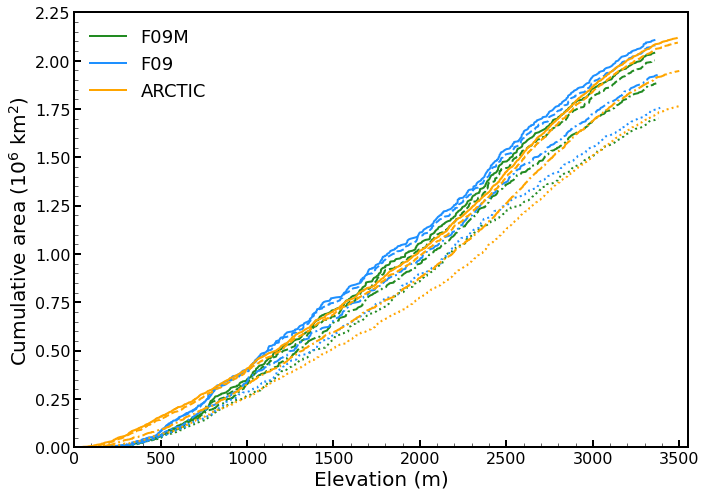

In [40]:
fig = plt.figure(figsize = (11,8))
gs=GridSpec(8,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2

#----------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0:8,0:11])

ax1.plot(f09_elev_PI.sortby(f09_elev_PI), f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax1.plot(f09_elev_stab.sortby(f09_elev_stab), f09_area_accum_stab.sortby(f09_area_accum_stab)/1e12, color = 'forestgreen', linewidth = line_width, linestyle='--');
ax1.plot(f09_elev_mid.sortby(f09_elev_mid), f09_area_accum_mid.sortby(f09_area_accum_mid)/1e12, color = 'forestgreen', linewidth = line_width, linestyle='-.');
ax1.plot(f09_elev_end.sortby(f09_elev_end), f09_area_accum_end.sortby(f09_area_accum_end)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');

ax1.plot(f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax1.plot(f09_nohacks_elev_stab.sortby(f09_nohacks_elev_stab), f09_nohacks_area_accum_stab.sortby(f09_nohacks_area_accum_stab)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle='--');
ax1.plot(f09_nohacks_elev_mid.sortby(f09_nohacks_elev_mid), f09_nohacks_area_accum_mid.sortby(f09_nohacks_area_accum_mid)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle='-.');
ax1.plot(f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');

ax1.plot(ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax1.plot(ARCTIC_elev_stab.sortby(ARCTIC_elev_stab), ARCTIC_area_accum_stab.sortby(ARCTIC_area_accum_stab)/1e12, color = 'orange', linewidth = line_width, linestyle='--');
ax1.plot(ARCTIC_elev_mid.sortby(ARCTIC_elev_mid), ARCTIC_area_accum_mid.sortby(ARCTIC_area_accum_mid)/1e12, color = 'orange', linewidth = line_width, linestyle='-.');
ax1.plot(ARCTIC_elev_end.sortby(ARCTIC_elev_end), ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax1.set_xlim([0, 3550])
ax1.set_ylim([0, 2.25])
ax1.set_xlabel('Elevation (m)', fontsize=size_label)
ax1.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)


plt.subplots_adjust(wspace=0.3)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Elevation_area_full.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

### 2.2 Get ELA

#### Read SMB data

In [17]:
## Arctic grid
ARCTIC_lon = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lat.nc')['lat']

# 1pctCO2
ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] 
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] 
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'] 
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'] 
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']

# 4xext
ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN']
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW']
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
ARCTIC_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']

In [18]:
## Concat
ARCTIC_1pctCO2_4xext_RAIN_yearly = xr.concat([ARCTIC_1pctCO2_RAIN_yearly, ARCTIC_4xext_RAIN_yearly], dim='time')
ARCTIC_1pctCO2_4xext_SNOW_yearly = xr.concat([ARCTIC_1pctCO2_SNOW_yearly, ARCTIC_4xext_SNOW_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([ARCTIC_1pctCO2_QICE_MELT_yearly, ARCTIC_4xext_QICE_MELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([ARCTIC_1pctCO2_QSNOMELT_yearly, ARCTIC_4xext_QSNOMELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly, ARCTIC_4xext_QFLX_EVAP_TOT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([ARCTIC_1pctCO2_QRUNOFF_yearly, ARCTIC_4xext_QRUNOFF_yearly], dim='time')

In [19]:
## Calculate SMB
#ARCTIC
ARCTIC_1pctCO2_4xext_SMB_yearly = ARCTIC_1pctCO2_4xext_RAIN_yearly + ARCTIC_1pctCO2_4xext_SNOW_yearly - ARCTIC_1pctCO2_4xext_QRUNOFF_yearly - ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly

#### Interpolate method (length weighted)

In [55]:
def Calculate_ELA_ARCTIC_ah_sqrt(phis, smb, mask, yr):

    # Mask the GrIS
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS = smb[yr,:].where(mask[yr,:]>0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS = phis[yr,:].where(mask[yr,:]>0)
    ARCTIC_area_GrIS = ARCTIC_area_coord.where(mask[yr,:]>0)
    ARCTIC_lon_GrIS = ARCTIC_lon.where(mask[yr,:]>0)
    ARCTIC_lat_GrIS = ARCTIC_lat.where(mask[yr,:]>0)
    ARCTIC_lon_corner_GrIS = ARCTIC_scrip.grid_corner_lon.copy() # Note: need copy() here!
    ARCTIC_lat_corner_GrIS = ARCTIC_scrip.grid_corner_lat.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS[:,i] = ARCTIC_scrip.grid_corner_lon[:,i].where(mask[yr,:]>0)
        ARCTIC_lat_corner_GrIS[:,i] = ARCTIC_scrip.grid_corner_lat[:,i].where(mask[yr,:]>0)

    # Mask the ablation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0) # Note: PHIS has dim 'ncol', not 'lndgrid' in smb
    ARCTIC_area_GrIS_abl = ARCTIC_area_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lon_GrIS_abl = ARCTIC_lon_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lat_GrIS_abl = ARCTIC_lat_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lon_corner_GrIS_abl = ARCTIC_lon_corner_GrIS.copy()
    ARCTIC_lat_corner_GrIS_abl = ARCTIC_lat_corner_GrIS.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS_abl[:,i] = ARCTIC_lon_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
        ARCTIC_lat_corner_GrIS_abl[:,i] = ARCTIC_lat_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)

    # Mask the accumulation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_area_GrIS_acc = ARCTIC_area_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lon_GrIS_acc = ARCTIC_lon_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lat_GrIS_acc = ARCTIC_lat_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lon_corner_GrIS_acc = ARCTIC_lon_corner_GrIS.copy()
    ARCTIC_lat_corner_GrIS_acc = ARCTIC_lat_corner_GrIS.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS_acc[:,i] = ARCTIC_lon_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
        ARCTIC_lat_corner_GrIS_acc[:,i] = ARCTIC_lat_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)

    # Remove nan values
    # ablation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl_dn = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl.dropna(dim='lndgrid')
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl_dn = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl.dropna(dim='ncol')
    ARCTIC_area_GrIS_abl_dn = ARCTIC_area_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lon_GrIS_abl_dn = ARCTIC_lon_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lat_GrIS_abl_dn = ARCTIC_lat_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lon_corner_GrIS_abl_dn = ARCTIC_lon_corner_GrIS_abl.dropna(dim='grid_size')
    ARCTIC_lat_corner_GrIS_abl_dn = ARCTIC_lat_corner_GrIS_abl.dropna(dim='grid_size')
    ARCTIC_area_GrIS_abl_dn = ARCTIC_area_GrIS_abl.dropna(dim='ncol')
    num_ablation_grid = len(ARCTIC_area_GrIS_abl_dn)
    # accumulation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc_dn = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc.dropna(dim='lndgrid')
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc_dn = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lon_GrIS_acc_dn = ARCTIC_lon_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lat_GrIS_acc_dn = ARCTIC_lat_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lon_corner_GrIS_acc_dn = ARCTIC_lon_corner_GrIS_acc.dropna(dim='grid_size')
    ARCTIC_lat_corner_GrIS_acc_dn = ARCTIC_lat_corner_GrIS_acc.dropna(dim='grid_size')
    ARCTIC_area_GrIS_acc_dn = ARCTIC_area_GrIS_acc.dropna(dim='ncol')
    num_accumulation_grid = len(ARCTIC_area_GrIS_acc_dn)

    # Create new variables
    grid_ELA_elev = []
    length = []

    for i in range(num_ablation_grid):
        # lon, lat of the ablation grid
        lon = ARCTIC_lon_GrIS_abl_dn[i].values
        lat = ARCTIC_lat_GrIS_abl_dn[i].values
        lon_corner = ARCTIC_lon_corner_GrIS_abl_dn[i,:]
        lat_corner = ARCTIC_lat_corner_GrIS_abl_dn[i,:]

        # Check if any of the neighboring four grids has >0 SMB
        for j in range(num_accumulation_grid):
            # limit the looping grids to a small nearby area
            if (abs(ARCTIC_lon_GrIS_acc_dn[j].values - lon) < 1) & (abs(ARCTIC_lat_GrIS_acc_dn[j].values - lat) < 1):
                lon_corner_acc = ARCTIC_lon_corner_GrIS_acc_dn[j,:]
                lat_corner_acc = ARCTIC_lat_corner_GrIS_acc_dn[j,:]

                # Remove duplicated lon,lat pairs
                lonlat_corner = xr.concat([lon_corner, lat_corner], 'new_dim')
                lonlat_corner_uni = np.unique(lonlat_corner, axis=1)
                lonlat_corner_acc = xr.concat([lon_corner_acc, lat_corner_acc], 'new_dim')
                lonlat_corner_acc_uni = np.unique(lonlat_corner_acc, axis=1)

                count = 0
                for k in range(lonlat_corner_uni.shape[1]):
                    if lonlat_corner_uni.T.tolist()[k] in lonlat_corner_acc_uni.T.tolist():
                        count = count + 1

                # Neighboring points
                if count >= 2:
                    grid_smb = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl_dn[i].values
                    grid_elev = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl_dn[i].values/g
                    grid_area = ARCTIC_area_GrIS_abl_dn[i].values
                    grid_acc_smb = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc_dn[j].values
                    grid_acc_elev = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc_dn[j].values/g
                    grid_acc_area = ARCTIC_area_GrIS_acc_dn[j].values
                    grid_ELA_elev.append(grid_elev + (grid_acc_elev - grid_elev) * ((0 - grid_smb) / (grid_acc_smb - grid_smb)))
                    length.append((sqrt(grid_area) + sqrt(grid_acc_area)) / 2)

    ARCTIC_1pctCO2_4xext_ELA = np.sum(np.array(grid_ELA_elev) * np.array(length)) / np.sum(np.array(length))

    return ARCTIC_1pctCO2_4xext_ELA

In [18]:
## Max and min values, read the result from compare_ablation.ipynb
# Since year 350 doesn't necessarily have the highest ELA, here we find the ELA range instead
ARCTIC_ela_GrIS_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')['ELA'].max()
print('Min ELA: ', ARCTIC_ela_GrIS_ah_sqrt_min.values)
print('Max ELA: ', ARCTIC_ela_GrIS_ah_sqrt_max.values)

Min ELA:  712.4462585596533
Max ELA:  2464.3082115258712


### 2.3 Divided by basins

#### Show the basins

In [90]:
f09_basinmask = xr.open_dataset(home_dir+'masks/GrIS/basinmask_adam/GrnDrainageSystems.f09.mask.nc')['basinmask']
ARCTIC_basinmask = xr.open_dataset(home_dir+'masks/GrIS/basinmask_adam/GrnDrainageSystems.ARCTIC.mask.nc')['basinmask']

In [91]:
# Scrip files (contains grid information)
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [23]:
# Modified from the Plot_2D() function with link below
def get_var_verts(scrip_fname, var_in):

    # Read scrip file in case of SE model output
    ds_scrip = xr.open_dataset(scrip_fname)
    corner_lon = np.copy(ds_scrip.grid_corner_lon.values)
    corner_lat = np.copy(ds_scrip.grid_corner_lat.values)
    center_lon = np.copy(ds_scrip.grid_center_lon.values)
    center_lat = np.copy(ds_scrip.grid_center_lat.values)

    var0 = var_in # [ ]
    var = np.copy(var0.values)
    lon_range = [-180, 180]

    if ((np.min(lon_range) < 0) & (np.max(corner_lon) > 180)):
        corner_lon[corner_lon > 180.] -= 360.

    # set vertices for SE model output
    lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0], corner_lon.shape[1],1))
    lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0], corner_lat.shape[1],1))
    lons_corners[lons_corners > 180.] -= 360
    center_lon[center_lon > 180.] -= 360

    lons_corners_add = []
    lats_corners_add = []
    var_add = []
    # For longitudes -180, 180
    for i, cenlon in enumerate(center_lon):
        lon_maxmin = np.max(lons_corners[i,:,:]) - \
                     np.min(lons_corners[i,:,:])
        if (lon_maxmin > 180):
            if np.mean(lons_corners[i,:,:]) <= 0:
                inds2 = np.where(lons_corners[i,:,:] < 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = 180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] > 0)[0]
                lons_corners[i,inds] = -180.

                var_add.append(var[i])

            elif np.mean(lons_corners[i,:,:]) > 0:
                inds2 = np.where(lons_corners[i,:,:] > 0)[0]
                tmp_lons_corners = np.copy(lons_corners[i,:])
                tmp_lons_corners[inds2] = -180.
                lons_corners_add.append(tmp_lons_corners)
                lats_corners_add.append(lats_corners[i,:])

                inds = np.where(lons_corners[i,:,:] < 0)[0]
                lons_corners[i,inds] = 180.

                var_add.append(var[i])

    lons_corners = np.concatenate((lons_corners, np.array(lons_corners_add)), axis=0)
    lats_corners = np.concatenate((lats_corners, np.array(lats_corners_add)), axis=0)
    var = np.concatenate((var, np.array(var_add)), axis=0)

    verts = np.concatenate((lons_corners, lats_corners), axis=2)
    
    return var, verts

In [44]:
ARCTIC_basinmask_var = get_var_verts(scrip_fname_ARCTIC, ARCTIC_basinmask)[0]
ARCTIC_basinmask_verts = get_var_verts(scrip_fname_ARCTIC, ARCTIC_basinmask)[1]

In [45]:
# Dictionary declaration for keywords in external function call
kwd_polycollection = {}
kwd_polycollection['edgecolor'] = 'face'
#kwd_polycollection['norm'] = \
#                    matplotlib.colors.SymLogNorm( linthresh=self.linthresh,
#                                                  linscale=self.linscale,
#                                                  vmin=self.cmin, vmax=self.cmax )

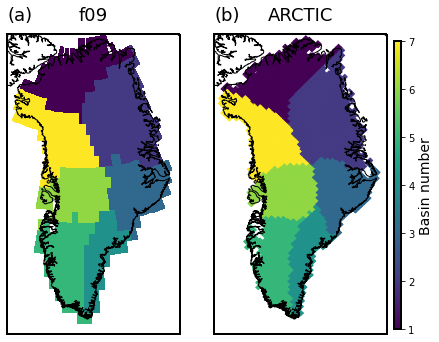

In [46]:
## Show the basins
# Number: 1-NO, 2-NE, 3-CE, 4-SE, 5-SW, 6-CW, 7-NW
fig = plt.figure(figsize = (6.8,6.2))
gs=GridSpec(1,2)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------1----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = plt.pcolormesh(f09_lon, f09_lat, f09_basinmask, transform = crs_ll)
plt.title('(a)', fontsize=18, loc='left')
plt.title('f09', fontsize=18, loc='center')

#---------------------------------------------2----------------------------------------------------
ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56.4, -29.6, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = PolyCollection(ARCTIC_basinmask_verts, transform=crs_ll,
                     **kwd_polycollection)
im2.set_array(ARCTIC_basinmask_var)
#im2.set_clim(vmin=0, vmax=3200)
ax2.add_collection(im2)
plt.title('(b)', fontsize=18, loc='left')
plt.title('ARCTIC', fontsize=18, loc='center')

# colorbar
cbar_ax1 = fig.add_axes([0.915, 0.178, 0.015, 0.644])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cb1.set_label(label='Basin number', size=14)
cb1.ax.tick_params(labelsize=10)


plt.subplots_adjust(wspace=0.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Basinmask.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

#### Calculate

In [92]:
#1-NO
# F09M
f09_PHIS_mask_PI_NO = f09_PHIS_mask_PI.where(f09_basinmask.values==1)
f09_area_mask_PI_NO = f09_area_mask_PI.where(f09_basinmask.values==1)
f09_PHIS_mask_stab_NO = f09_PHIS_mask_stab.where(f09_basinmask.values==1)
f09_area_mask_stab_NO = f09_area_mask_stab.where(f09_basinmask.values==1)
f09_PHIS_mask_mid_NO = f09_PHIS_mask_mid.where(f09_basinmask.values==1)
f09_area_mask_mid_NO = f09_area_mask_mid.where(f09_basinmask.values==1)
f09_PHIS_mask_end_NO = f09_PHIS_mask_end.where(f09_basinmask.values==1)
f09_area_mask_end_NO = f09_area_mask_end.where(f09_basinmask.values==1)
# F09
f09_nohacks_PHIS_mask_PI_NO = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==1)
f09_nohacks_area_mask_PI_NO = f09_nohacks_area_mask_PI.where(f09_basinmask.values==1)
f09_nohacks_PHIS_mask_stab_NO = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==1)
f09_nohacks_area_mask_stab_NO = f09_nohacks_area_mask_stab.where(f09_basinmask.values==1)
f09_nohacks_PHIS_mask_mid_NO = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==1)
f09_nohacks_area_mask_mid_NO = f09_nohacks_area_mask_mid.where(f09_basinmask.values==1)
f09_nohacks_PHIS_mask_end_NO = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==1)
f09_nohacks_area_mask_end_NO = f09_nohacks_area_mask_end.where(f09_basinmask.values==1)
# ARCTIC
ARCTIC_PHIS_mask_PI_NO = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==1)
ARCTIC_area_mask_PI_NO = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==1)
ARCTIC_PHIS_mask_stab_NO = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==1)
ARCTIC_area_mask_stab_NO = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==1)
ARCTIC_PHIS_mask_mid_NO = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==1)
ARCTIC_area_mask_mid_NO = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==1)
ARCTIC_PHIS_mask_end_NO = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==1)
ARCTIC_area_mask_end_NO = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==1)

#2-NE
# F09M
f09_PHIS_mask_PI_NE = f09_PHIS_mask_PI.where(f09_basinmask.values==2)
f09_area_mask_PI_NE = f09_area_mask_PI.where(f09_basinmask.values==2)
f09_PHIS_mask_stab_NE = f09_PHIS_mask_stab.where(f09_basinmask.values==2)
f09_area_mask_stab_NE = f09_area_mask_stab.where(f09_basinmask.values==2)
f09_PHIS_mask_mid_NE = f09_PHIS_mask_mid.where(f09_basinmask.values==2)
f09_area_mask_mid_NE = f09_area_mask_mid.where(f09_basinmask.values==2)
f09_PHIS_mask_end_NE = f09_PHIS_mask_end.where(f09_basinmask.values==2)
f09_area_mask_end_NE = f09_area_mask_end.where(f09_basinmask.values==2)
# F09
f09_nohacks_PHIS_mask_PI_NE = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==2)
f09_nohacks_area_mask_PI_NE = f09_nohacks_area_mask_PI.where(f09_basinmask.values==2)
f09_nohacks_PHIS_mask_stab_NE = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==2)
f09_nohacks_area_mask_stab_NE = f09_nohacks_area_mask_stab.where(f09_basinmask.values==2)
f09_nohacks_PHIS_mask_mid_NE = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==2)
f09_nohacks_area_mask_mid_NE = f09_nohacks_area_mask_mid.where(f09_basinmask.values==2)
f09_nohacks_PHIS_mask_end_NE = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==2)
f09_nohacks_area_mask_end_NE = f09_nohacks_area_mask_end.where(f09_basinmask.values==2)
# ARCTIC
ARCTIC_PHIS_mask_PI_NE = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==2)
ARCTIC_area_mask_PI_NE = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==2)
ARCTIC_PHIS_mask_stab_NE = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==2)
ARCTIC_area_mask_stab_NE = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==2)
ARCTIC_PHIS_mask_mid_NE = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==2)
ARCTIC_area_mask_mid_NE = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==2)
ARCTIC_PHIS_mask_end_NE = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==2)
ARCTIC_area_mask_end_NE = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==2)

#3-CE
# F09M
f09_PHIS_mask_PI_CE = f09_PHIS_mask_PI.where(f09_basinmask.values==3)
f09_area_mask_PI_CE = f09_area_mask_PI.where(f09_basinmask.values==3)
f09_PHIS_mask_stab_CE = f09_PHIS_mask_stab.where(f09_basinmask.values==3)
f09_area_mask_stab_CE = f09_area_mask_stab.where(f09_basinmask.values==3)
f09_PHIS_mask_mid_CE = f09_PHIS_mask_mid.where(f09_basinmask.values==3)
f09_area_mask_mid_CE = f09_area_mask_mid.where(f09_basinmask.values==3)
f09_PHIS_mask_end_CE = f09_PHIS_mask_end.where(f09_basinmask.values==3)
f09_area_mask_end_CE = f09_area_mask_end.where(f09_basinmask.values==3)
# F09
f09_nohacks_PHIS_mask_PI_CE = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==3)
f09_nohacks_area_mask_PI_CE = f09_nohacks_area_mask_PI.where(f09_basinmask.values==3)
f09_nohacks_PHIS_mask_stab_CE = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==3)
f09_nohacks_area_mask_stab_CE = f09_nohacks_area_mask_stab.where(f09_basinmask.values==3)
f09_nohacks_PHIS_mask_mid_CE = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==3)
f09_nohacks_area_mask_mid_CE = f09_nohacks_area_mask_mid.where(f09_basinmask.values==3)
f09_nohacks_PHIS_mask_end_CE = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==3)
f09_nohacks_area_mask_end_CE = f09_nohacks_area_mask_end.where(f09_basinmask.values==3)
# ARCTIC
ARCTIC_PHIS_mask_PI_CE = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==3)
ARCTIC_area_mask_PI_CE = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==3)
ARCTIC_PHIS_mask_stab_CE = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==3)
ARCTIC_area_mask_stab_CE = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==3)
ARCTIC_PHIS_mask_mid_CE = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==3)
ARCTIC_area_mask_mid_CE = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==3)
ARCTIC_PHIS_mask_end_CE = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==3)
ARCTIC_area_mask_end_CE = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==3)

#4-SE
# F09M
f09_PHIS_mask_PI_SE = f09_PHIS_mask_PI.where(f09_basinmask.values==4)
f09_area_mask_PI_SE = f09_area_mask_PI.where(f09_basinmask.values==4)
f09_PHIS_mask_stab_SE = f09_PHIS_mask_stab.where(f09_basinmask.values==4)
f09_area_mask_stab_SE = f09_area_mask_stab.where(f09_basinmask.values==4)
f09_PHIS_mask_mid_SE = f09_PHIS_mask_mid.where(f09_basinmask.values==4)
f09_area_mask_mid_SE = f09_area_mask_mid.where(f09_basinmask.values==4)
f09_PHIS_mask_end_SE = f09_PHIS_mask_end.where(f09_basinmask.values==4)
f09_area_mask_end_SE = f09_area_mask_end.where(f09_basinmask.values==4)
# F09
f09_nohacks_PHIS_mask_PI_SE = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==4)
f09_nohacks_area_mask_PI_SE = f09_nohacks_area_mask_PI.where(f09_basinmask.values==4)
f09_nohacks_PHIS_mask_stab_SE = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==4)
f09_nohacks_area_mask_stab_SE = f09_nohacks_area_mask_stab.where(f09_basinmask.values==4)
f09_nohacks_PHIS_mask_mid_SE = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==4)
f09_nohacks_area_mask_mid_SE = f09_nohacks_area_mask_mid.where(f09_basinmask.values==4)
f09_nohacks_PHIS_mask_end_SE = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==4)
f09_nohacks_area_mask_end_SE = f09_nohacks_area_mask_end.where(f09_basinmask.values==4)
# ARCTIC
ARCTIC_PHIS_mask_PI_SE = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==4)
ARCTIC_area_mask_PI_SE = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==4)
ARCTIC_PHIS_mask_stab_SE = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==4)
ARCTIC_area_mask_stab_SE = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==4)
ARCTIC_PHIS_mask_mid_SE = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==4)
ARCTIC_area_mask_mid_SE = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==4)
ARCTIC_PHIS_mask_end_SE = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==4)
ARCTIC_area_mask_end_SE = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==4)

#5-SW
# F09M
f09_PHIS_mask_PI_SW = f09_PHIS_mask_PI.where(f09_basinmask.values==5)
f09_area_mask_PI_SW = f09_area_mask_PI.where(f09_basinmask.values==5)
f09_PHIS_mask_stab_SW = f09_PHIS_mask_stab.where(f09_basinmask.values==5)
f09_area_mask_stab_SW = f09_area_mask_stab.where(f09_basinmask.values==5)
f09_PHIS_mask_mid_SW = f09_PHIS_mask_mid.where(f09_basinmask.values==5)
f09_area_mask_mid_SW = f09_area_mask_mid.where(f09_basinmask.values==5)
f09_PHIS_mask_end_SW = f09_PHIS_mask_end.where(f09_basinmask.values==5)
f09_area_mask_end_SW = f09_area_mask_end.where(f09_basinmask.values==5)
# F09
f09_nohacks_PHIS_mask_PI_SW = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==5)
f09_nohacks_area_mask_PI_SW = f09_nohacks_area_mask_PI.where(f09_basinmask.values==5)
f09_nohacks_PHIS_mask_stab_SW = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==5)
f09_nohacks_area_mask_stab_SW = f09_nohacks_area_mask_stab.where(f09_basinmask.values==5)
f09_nohacks_PHIS_mask_mid_SW = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==5)
f09_nohacks_area_mask_mid_SW = f09_nohacks_area_mask_mid.where(f09_basinmask.values==5)
f09_nohacks_PHIS_mask_end_SW = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==5)
f09_nohacks_area_mask_end_SW = f09_nohacks_area_mask_end.where(f09_basinmask.values==5)
# ARCTIC
ARCTIC_PHIS_mask_PI_SW = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==5)
ARCTIC_area_mask_PI_SW = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==5)
ARCTIC_PHIS_mask_stab_SW = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==5)
ARCTIC_area_mask_stab_SW = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==5)
ARCTIC_PHIS_mask_mid_SW = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==5)
ARCTIC_area_mask_mid_SW = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==5)
ARCTIC_PHIS_mask_end_SW = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==5)
ARCTIC_area_mask_end_SW = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==5)

#6-CW
# F09M
f09_PHIS_mask_PI_CW = f09_PHIS_mask_PI.where(f09_basinmask.values==6)
f09_area_mask_PI_CW = f09_area_mask_PI.where(f09_basinmask.values==6)
f09_PHIS_mask_stab_CW = f09_PHIS_mask_stab.where(f09_basinmask.values==6)
f09_area_mask_stab_CW = f09_area_mask_stab.where(f09_basinmask.values==6)
f09_PHIS_mask_mid_CW = f09_PHIS_mask_mid.where(f09_basinmask.values==6)
f09_area_mask_mid_CW = f09_area_mask_mid.where(f09_basinmask.values==6)
f09_PHIS_mask_end_CW = f09_PHIS_mask_end.where(f09_basinmask.values==6)
f09_area_mask_end_CW = f09_area_mask_end.where(f09_basinmask.values==6)
# F09
f09_nohacks_PHIS_mask_PI_CW = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==6)
f09_nohacks_area_mask_PI_CW = f09_nohacks_area_mask_PI.where(f09_basinmask.values==6)
f09_nohacks_PHIS_mask_stab_CW = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==6)
f09_nohacks_area_mask_stab_CW = f09_nohacks_area_mask_stab.where(f09_basinmask.values==6)
f09_nohacks_PHIS_mask_mid_CW = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==6)
f09_nohacks_area_mask_mid_CW = f09_nohacks_area_mask_mid.where(f09_basinmask.values==6)
f09_nohacks_PHIS_mask_end_CW = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==6)
f09_nohacks_area_mask_end_CW = f09_nohacks_area_mask_end.where(f09_basinmask.values==6)
# ARCTIC
ARCTIC_PHIS_mask_PI_CW = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==6)
ARCTIC_area_mask_PI_CW = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==6)
ARCTIC_PHIS_mask_stab_CW = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==6)
ARCTIC_area_mask_stab_CW = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==6)
ARCTIC_PHIS_mask_mid_CW = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==6)
ARCTIC_area_mask_mid_CW = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==6)
ARCTIC_PHIS_mask_end_CW = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==6)
ARCTIC_area_mask_end_CW = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==6)

#7-NW
# F09M
f09_PHIS_mask_PI_NW = f09_PHIS_mask_PI.where(f09_basinmask.values==7)
f09_area_mask_PI_NW = f09_area_mask_PI.where(f09_basinmask.values==7)
f09_PHIS_mask_stab_NW = f09_PHIS_mask_stab.where(f09_basinmask.values==7)
f09_area_mask_stab_NW = f09_area_mask_stab.where(f09_basinmask.values==7)
f09_PHIS_mask_mid_NW = f09_PHIS_mask_mid.where(f09_basinmask.values==7)
f09_area_mask_mid_NW = f09_area_mask_mid.where(f09_basinmask.values==7)
f09_PHIS_mask_end_NW = f09_PHIS_mask_end.where(f09_basinmask.values==7)
f09_area_mask_end_NW = f09_area_mask_end.where(f09_basinmask.values==7)
# F09
f09_nohacks_PHIS_mask_PI_NW = f09_nohacks_PHIS_mask_PI.where(f09_basinmask.values==7)
f09_nohacks_area_mask_PI_NW = f09_nohacks_area_mask_PI.where(f09_basinmask.values==7)
f09_nohacks_PHIS_mask_stab_NW = f09_nohacks_PHIS_mask_stab.where(f09_basinmask.values==7)
f09_nohacks_area_mask_stab_NW = f09_nohacks_area_mask_stab.where(f09_basinmask.values==7)
f09_nohacks_PHIS_mask_mid_NW = f09_nohacks_PHIS_mask_mid.where(f09_basinmask.values==7)
f09_nohacks_area_mask_mid_NW = f09_nohacks_area_mask_mid.where(f09_basinmask.values==7)
f09_nohacks_PHIS_mask_end_NW = f09_nohacks_PHIS_mask_end.where(f09_basinmask.values==7)
f09_nohacks_area_mask_end_NW = f09_nohacks_area_mask_end.where(f09_basinmask.values==7)
# ARCTIC
ARCTIC_PHIS_mask_PI_NW = ARCTIC_PHIS_mask_PI.where(ARCTIC_basinmask.values==7)
ARCTIC_area_mask_PI_NW = ARCTIC_area_mask_PI.where(ARCTIC_basinmask.values==7)
ARCTIC_PHIS_mask_stab_NW = ARCTIC_PHIS_mask_stab.where(ARCTIC_basinmask.values==7)
ARCTIC_area_mask_stab_NW = ARCTIC_area_mask_stab.where(ARCTIC_basinmask.values==7)
ARCTIC_PHIS_mask_mid_NW = ARCTIC_PHIS_mask_mid.where(ARCTIC_basinmask.values==7)
ARCTIC_area_mask_mid_NW = ARCTIC_area_mask_mid.where(ARCTIC_basinmask.values==7)
ARCTIC_PHIS_mask_end_NW = ARCTIC_PHIS_mask_end.where(ARCTIC_basinmask.values==7)
ARCTIC_area_mask_end_NW = ARCTIC_area_mask_end.where(ARCTIC_basinmask.values==7)

In [93]:
## Drop NAN values
# 1-NO
# F09M
f09_elev_PI_NO = f09_PHIS_mask_PI_NO.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_NO = f09_area_mask_PI_NO.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_NO = f09_PHIS_mask_end_NO.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_NO = f09_area_mask_end_NO.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_NO = f09_nohacks_PHIS_mask_PI_NO.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_NO = f09_nohacks_area_mask_PI_NO.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_NO = f09_nohacks_PHIS_mask_end_NO.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_NO = f09_nohacks_area_mask_end_NO.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_NO = ARCTIC_PHIS_mask_PI_NO.dropna(dim='ncol')/g
ARCTIC_area_PI_NO = ARCTIC_area_mask_PI_NO.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_NO = ARCTIC_PHIS_mask_end_NO.dropna(dim='ncol')/g
ARCTIC_area_end_NO = ARCTIC_area_mask_end_NO.squeeze().dropna(dim='ncol')

# 2-NE
# F09M
f09_elev_PI_NE = f09_PHIS_mask_PI_NE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_NE = f09_area_mask_PI_NE.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_NE = f09_PHIS_mask_end_NE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_NE = f09_area_mask_end_NE.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_NE = f09_nohacks_PHIS_mask_PI_NE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_NE = f09_nohacks_area_mask_PI_NE.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_NE = f09_nohacks_PHIS_mask_end_NE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_NE = f09_nohacks_area_mask_end_NE.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_NE = ARCTIC_PHIS_mask_PI_NE.dropna(dim='ncol')/g
ARCTIC_area_PI_NE = ARCTIC_area_mask_PI_NE.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_NE = ARCTIC_PHIS_mask_end_NE.dropna(dim='ncol')/g
ARCTIC_area_end_NE = ARCTIC_area_mask_end_NE.squeeze().dropna(dim='ncol')

# 3-CE
# F09M
f09_elev_PI_CE = f09_PHIS_mask_PI_CE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_CE = f09_area_mask_PI_CE.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_CE = f09_PHIS_mask_end_CE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_CE = f09_area_mask_end_CE.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_CE = f09_nohacks_PHIS_mask_PI_CE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_CE = f09_nohacks_area_mask_PI_CE.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_CE = f09_nohacks_PHIS_mask_end_CE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_CE = f09_nohacks_area_mask_end_CE.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_CE = ARCTIC_PHIS_mask_PI_CE.dropna(dim='ncol')/g
ARCTIC_area_PI_CE = ARCTIC_area_mask_PI_CE.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_CE = ARCTIC_PHIS_mask_end_CE.dropna(dim='ncol')/g
ARCTIC_area_end_CE = ARCTIC_area_mask_end_CE.squeeze().dropna(dim='ncol')

# 4-SE
# F09M
f09_elev_PI_SE = f09_PHIS_mask_PI_SE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_SE = f09_area_mask_PI_SE.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_SE = f09_PHIS_mask_end_SE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_SE = f09_area_mask_end_SE.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_SE = f09_nohacks_PHIS_mask_PI_SE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_SE = f09_nohacks_area_mask_PI_SE.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_SE = f09_nohacks_PHIS_mask_end_SE.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_SE = f09_nohacks_area_mask_end_SE.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_SE = ARCTIC_PHIS_mask_PI_SE.dropna(dim='ncol')/g
ARCTIC_area_PI_SE = ARCTIC_area_mask_PI_SE.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_SE = ARCTIC_PHIS_mask_end_SE.dropna(dim='ncol')/g
ARCTIC_area_end_SE = ARCTIC_area_mask_end_SE.squeeze().dropna(dim='ncol')

# 5-SW
# F09M
f09_elev_PI_SW = f09_PHIS_mask_PI_SW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_SW = f09_area_mask_PI_SW.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_SW = f09_PHIS_mask_end_SW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_SW = f09_area_mask_end_SW.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_SW = f09_nohacks_PHIS_mask_PI_SW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_SW = f09_nohacks_area_mask_PI_SW.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_SW = f09_nohacks_PHIS_mask_end_SW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_SW = f09_nohacks_area_mask_end_SW.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_SW = ARCTIC_PHIS_mask_PI_SW.dropna(dim='ncol')/g
ARCTIC_area_PI_SW = ARCTIC_area_mask_PI_SW.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_SW = ARCTIC_PHIS_mask_end_SW.dropna(dim='ncol')/g
ARCTIC_area_end_SW = ARCTIC_area_mask_end_SW.squeeze().dropna(dim='ncol')

# 6-CW
# F09M
f09_elev_PI_CW = f09_PHIS_mask_PI_CW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_CW = f09_area_mask_PI_CW.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_CW = f09_PHIS_mask_end_CW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_CW = f09_area_mask_end_CW.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_CW = f09_nohacks_PHIS_mask_PI_CW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_CW = f09_nohacks_area_mask_PI_CW.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_CW = f09_nohacks_PHIS_mask_end_CW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_CW = f09_nohacks_area_mask_end_CW.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_CW = ARCTIC_PHIS_mask_PI_CW.dropna(dim='ncol')/g
ARCTIC_area_PI_CW = ARCTIC_area_mask_PI_CW.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_CW = ARCTIC_PHIS_mask_end_CW.dropna(dim='ncol')/g
ARCTIC_area_end_CW = ARCTIC_area_mask_end_CW.squeeze().dropna(dim='ncol')

# 7-NW
# F09M
f09_elev_PI_NW = f09_PHIS_mask_PI_NW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_PI_NW = f09_area_mask_PI_NW.stack(p=('lat','lon')).dropna(dim='p')
f09_elev_end_NW = f09_PHIS_mask_end_NW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_area_end_NW = f09_area_mask_end_NW.stack(p=('lat','lon')).dropna(dim='p')
# F09
f09_nohacks_elev_PI_NW = f09_nohacks_PHIS_mask_PI_NW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_PI_NW = f09_nohacks_area_mask_PI_NW.stack(p=('lat','lon')).dropna(dim='p')
f09_nohacks_elev_end_NW = f09_nohacks_PHIS_mask_end_NW.stack(p=('lat','lon')).dropna(dim='p')/g
f09_nohacks_area_end_NW = f09_nohacks_area_mask_end_NW.stack(p=('lat','lon')).dropna(dim='p')
# ARCTIC
ARCTIC_elev_PI_NW = ARCTIC_PHIS_mask_PI_NW.dropna(dim='ncol')/g
ARCTIC_area_PI_NW = ARCTIC_area_mask_PI_NW.squeeze().dropna(dim='ncol')
ARCTIC_elev_end_NW = ARCTIC_PHIS_mask_end_NW.dropna(dim='ncol')/g
ARCTIC_area_end_NW = ARCTIC_area_mask_end_NW.squeeze().dropna(dim='ncol')

In [94]:
## Calculate accumulated area
# 1-NO
# F09M
f09_area_accum_PI_NO = f09_area_PI_NO * 0
for i in range(len(f09_area_PI_NO)):
    f09_area_accum_PI_NO[i] = f09_area_PI_NO.where(f09_elev_PI_NO.values <= f09_elev_PI_NO[i].values).sum(dim='p')
f09_area_accum_end_NO = f09_area_end_NO * 0
for i in range(len(f09_area_end_NO)):
    f09_area_accum_end_NO[i] = f09_area_end_NO.where(f09_elev_end_NO.values <= f09_elev_end_NO[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_NO = f09_nohacks_area_PI_NO * 0
for i in range(len(f09_nohacks_area_PI_NO)):
    f09_nohacks_area_accum_PI_NO[i] = f09_nohacks_area_PI_NO.where(f09_nohacks_elev_PI_NO.values <= f09_nohacks_elev_PI_NO[i].values).sum(dim='p')        
f09_nohacks_area_accum_end_NO = f09_nohacks_area_end_NO * 0
for i in range(len(f09_nohacks_area_end_NO)):
    f09_nohacks_area_accum_end_NO[i] = f09_nohacks_area_end_NO.where(f09_nohacks_elev_end_NO.values <= f09_nohacks_elev_end_NO[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_NO = ARCTIC_area_PI_NO * 0
for i in range(len(ARCTIC_area_PI_NO)):
    ARCTIC_area_accum_PI_NO[i] = ARCTIC_area_PI_NO.where(ARCTIC_elev_PI_NO.values <= ARCTIC_elev_PI_NO[i].values).sum(dim='ncol')  
ARCTIC_area_accum_end_NO = ARCTIC_area_end_NO * 0
for i in range(len(ARCTIC_area_end_NO)):
    ARCTIC_area_accum_end_NO[i] = ARCTIC_area_end_NO.where(ARCTIC_elev_end_NO.values <= ARCTIC_elev_end_NO[i].values).sum(dim='ncol')

# 2-NE
# F09M
f09_area_accum_PI_NE = f09_area_PI_NE * 0
for i in range(len(f09_area_PI_NE)):
    f09_area_accum_PI_NE[i] = f09_area_PI_NE.where(f09_elev_PI_NE.values <= f09_elev_PI_NE[i].values).sum(dim='p')
f09_area_accum_end_NE = f09_area_end_NE * 0
for i in range(len(f09_area_end_NE)):
    f09_area_accum_end_NE[i] = f09_area_end_NE.where(f09_elev_end_NE.values <= f09_elev_end_NE[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_NE = f09_nohacks_area_PI_NE * 0
for i in range(len(f09_nohacks_area_PI_NE)):
    f09_nohacks_area_accum_PI_NE[i] = f09_nohacks_area_PI_NE.where(f09_nohacks_elev_PI_NE.values <= f09_nohacks_elev_PI_NE[i].values).sum(dim='p')        
f09_nohacks_area_accum_end_NE = f09_nohacks_area_end_NE * 0
for i in range(len(f09_nohacks_area_end_NE)):
    f09_nohacks_area_accum_end_NE[i] = f09_nohacks_area_end_NE.where(f09_nohacks_elev_end_NE.values <= f09_nohacks_elev_end_NE[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_NE = ARCTIC_area_PI_NE * 0
for i in range(len(ARCTIC_area_PI_NE)):
    ARCTIC_area_accum_PI_NE[i] = ARCTIC_area_PI_NE.where(ARCTIC_elev_PI_NE.values <= ARCTIC_elev_PI_NE[i].values).sum(dim='ncol')  
ARCTIC_area_accum_end_NE = ARCTIC_area_end_NE * 0
for i in range(len(ARCTIC_area_end_NE)):
    ARCTIC_area_accum_end_NE[i] = ARCTIC_area_end_NE.where(ARCTIC_elev_end_NE.values <= ARCTIC_elev_end_NE[i].values).sum(dim='ncol')

# 3-CE
# F09M
f09_area_accum_PI_CE = f09_area_PI_CE * 0
for i in range(len(f09_area_PI_CE)):
    f09_area_accum_PI_CE[i] = f09_area_PI_CE.where(f09_elev_PI_CE.values <= f09_elev_PI_CE[i].values).sum(dim='p')
f09_area_accum_end_CE = f09_area_end_CE * 0
for i in range(len(f09_area_end_CE)):
    f09_area_accum_end_CE[i] = f09_area_end_CE.where(f09_elev_end_CE.values <= f09_elev_end_CE[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_CE = f09_nohacks_area_PI_CE * 0
for i in range(len(f09_nohacks_area_PI_CE)):
    f09_nohacks_area_accum_PI_CE[i] = f09_nohacks_area_PI_CE.where(f09_nohacks_elev_PI_CE.values <= f09_nohacks_elev_PI_CE[i].values).sum(dim='p')        
f09_nohacks_area_accum_end_CE = f09_nohacks_area_end_CE * 0
for i in range(len(f09_nohacks_area_end_CE)):
    f09_nohacks_area_accum_end_CE[i] = f09_nohacks_area_end_CE.where(f09_nohacks_elev_end_CE.values <= f09_nohacks_elev_end_CE[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_CE = ARCTIC_area_PI_CE * 0
for i in range(len(ARCTIC_area_PI_CE)):
    ARCTIC_area_accum_PI_CE[i] = ARCTIC_area_PI_CE.where(ARCTIC_elev_PI_CE.values <= ARCTIC_elev_PI_CE[i].values).sum(dim='ncol')  
ARCTIC_area_accum_end_CE = ARCTIC_area_end_CE * 0
for i in range(len(ARCTIC_area_end_CE)):
    ARCTIC_area_accum_end_CE[i] = ARCTIC_area_end_CE.where(ARCTIC_elev_end_CE.values <= ARCTIC_elev_end_CE[i].values).sum(dim='ncol')
    
# 4-SE
# F09M
f09_area_accum_PI_SE = f09_area_PI_SE * 0
for i in range(len(f09_area_PI_SE)):
    f09_area_accum_PI_SE[i] = f09_area_PI_SE.where(f09_elev_PI_SE.values <= f09_elev_PI_SE[i].values).sum(dim='p')
f09_area_accum_end_SE = f09_area_end_SE * 0
for i in range(len(f09_area_end_SE)):
    f09_area_accum_end_SE[i] = f09_area_end_SE.where(f09_elev_end_SE.values <= f09_elev_end_SE[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_SE = f09_nohacks_area_PI_SE * 0
for i in range(len(f09_nohacks_area_PI_SE)):
    f09_nohacks_area_accum_PI_SE[i] = f09_nohacks_area_PI_SE.where(f09_nohacks_elev_PI_SE.values <= f09_nohacks_elev_PI_SE[i].values).sum(dim='p')        
f09_nohacks_area_accum_end_SE = f09_nohacks_area_end_SE * 0
for i in range(len(f09_nohacks_area_end_SE)):
    f09_nohacks_area_accum_end_SE[i] = f09_nohacks_area_end_SE.where(f09_nohacks_elev_end_SE.values <= f09_nohacks_elev_end_SE[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_SE = ARCTIC_area_PI_SE * 0
for i in range(len(ARCTIC_area_PI_SE)):
    ARCTIC_area_accum_PI_SE[i] = ARCTIC_area_PI_SE.where(ARCTIC_elev_PI_SE.values <= ARCTIC_elev_PI_SE[i].values).sum(dim='ncol')  
ARCTIC_area_accum_end_SE = ARCTIC_area_end_SE * 0
for i in range(len(ARCTIC_area_end_SE)):
    ARCTIC_area_accum_end_SE[i] = ARCTIC_area_end_SE.where(ARCTIC_elev_end_SE.values <= ARCTIC_elev_end_SE[i].values).sum(dim='ncol')
    
# 5-SW
# F09M
f09_area_accum_PI_SW = f09_area_PI_SW * 0
for i in range(len(f09_area_PI_SW)):
    f09_area_accum_PI_SW[i] = f09_area_PI_SW.where(f09_elev_PI_SW.values <= f09_elev_PI_SW[i].values).sum(dim='p')
f09_area_accum_end_SW = f09_area_end_SW * 0
for i in range(len(f09_area_end_SW)):
    f09_area_accum_end_SW[i] = f09_area_end_SW.where(f09_elev_end_SW.values <= f09_elev_end_SW[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_SW = f09_nohacks_area_PI_SW * 0
for i in range(len(f09_nohacks_area_PI_SW)):
    f09_nohacks_area_accum_PI_SW[i] = f09_nohacks_area_PI_SW.where(f09_nohacks_elev_PI_SW.values <= f09_nohacks_elev_PI_SW[i].values).sum(dim='p')
f09_nohacks_area_accum_end_SW = f09_nohacks_area_end_SW * 0
for i in range(len(f09_nohacks_area_end_SW)):
    f09_nohacks_area_accum_end_SW[i] = f09_nohacks_area_end_SW.where(f09_nohacks_elev_end_SW.values <= f09_nohacks_elev_end_SW[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_SW = ARCTIC_area_PI_SW * 0
for i in range(len(ARCTIC_area_PI_SW)):
    ARCTIC_area_accum_PI_SW[i] = ARCTIC_area_PI_SW.where(ARCTIC_elev_PI_SW.values <= ARCTIC_elev_PI_SW[i].values).sum(dim='ncol')
ARCTIC_area_accum_end_SW = ARCTIC_area_end_SW * 0
for i in range(len(ARCTIC_area_end_SW)):
    ARCTIC_area_accum_end_SW[i] = ARCTIC_area_end_SW.where(ARCTIC_elev_end_SW.values <= ARCTIC_elev_end_SW[i].values).sum(dim='ncol')
    
# 6-CW
# F09M
f09_area_accum_PI_CW = f09_area_PI_CW * 0
for i in range(len(f09_area_PI_CW)):
    f09_area_accum_PI_CW[i] = f09_area_PI_CW.where(f09_elev_PI_CW.values <= f09_elev_PI_CW[i].values).sum(dim='p')
f09_area_accum_end_CW = f09_area_end_CW * 0
for i in range(len(f09_area_end_CW)):
    f09_area_accum_end_CW[i] = f09_area_end_CW.where(f09_elev_end_CW.values <= f09_elev_end_CW[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_CW = f09_nohacks_area_PI_CW * 0
for i in range(len(f09_nohacks_area_PI_CW)):
    f09_nohacks_area_accum_PI_CW[i] = f09_nohacks_area_PI_CW.where(f09_nohacks_elev_PI_CW.values <= f09_nohacks_elev_PI_CW[i].values).sum(dim='p')
f09_nohacks_area_accum_end_CW = f09_nohacks_area_end_CW * 0
for i in range(len(f09_nohacks_area_end_CW)):
    f09_nohacks_area_accum_end_CW[i] = f09_nohacks_area_end_CW.where(f09_nohacks_elev_end_CW.values <= f09_nohacks_elev_end_CW[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_CW = ARCTIC_area_PI_CW * 0
for i in range(len(ARCTIC_area_PI_CW)):
    ARCTIC_area_accum_PI_CW[i] = ARCTIC_area_PI_CW.where(ARCTIC_elev_PI_CW.values <= ARCTIC_elev_PI_CW[i].values).sum(dim='ncol')
ARCTIC_area_accum_end_CW = ARCTIC_area_end_CW * 0
for i in range(len(ARCTIC_area_end_CW)):
    ARCTIC_area_accum_end_CW[i] = ARCTIC_area_end_CW.where(ARCTIC_elev_end_CW.values <= ARCTIC_elev_end_CW[i].values).sum(dim='ncol')
    
# 7-NW
# F09M
f09_area_accum_PI_NW = f09_area_PI_NW * 0
for i in range(len(f09_area_PI_NW)):
    f09_area_accum_PI_NW[i] = f09_area_PI_NW.where(f09_elev_PI_NW.values <= f09_elev_PI_NW[i].values).sum(dim='p')
f09_area_accum_end_NW = f09_area_end_NW * 0
for i in range(len(f09_area_end_NW)):
    f09_area_accum_end_NW[i] = f09_area_end_NW.where(f09_elev_end_NW.values <= f09_elev_end_NW[i].values).sum(dim='p')
# F09
f09_nohacks_area_accum_PI_NW = f09_nohacks_area_PI_NW * 0
for i in range(len(f09_nohacks_area_PI_NW)):
    f09_nohacks_area_accum_PI_NW[i] = f09_nohacks_area_PI_NW.where(f09_nohacks_elev_PI_NW.values <= f09_nohacks_elev_PI_NW[i].values).sum(dim='p')
f09_nohacks_area_accum_end_NW = f09_nohacks_area_end_NW * 0
for i in range(len(f09_nohacks_area_end_NW)):
    f09_nohacks_area_accum_end_NW[i] = f09_nohacks_area_end_NW.where(f09_nohacks_elev_end_NW.values <= f09_nohacks_elev_end_NW[i].values).sum(dim='p')
# ARCTIC
ARCTIC_area_accum_PI_NW = ARCTIC_area_PI_NW * 0
for i in range(len(ARCTIC_area_PI_NW)):
    ARCTIC_area_accum_PI_NW[i] = ARCTIC_area_PI_NW.where(ARCTIC_elev_PI_NW.values <= ARCTIC_elev_PI_NW[i].values).sum(dim='ncol')
ARCTIC_area_accum_end_NW = ARCTIC_area_end_NW * 0
for i in range(len(ARCTIC_area_end_NW)):
    ARCTIC_area_accum_end_NW[i] = ARCTIC_area_end_NW.where(ARCTIC_elev_end_NW.values <= ARCTIC_elev_end_NW[i].values).sum(dim='ncol')

#### Get ELA - interpolate method (length weighted)

1-NO

In [ ]:
ARCTIC_ela_GrIS_b1_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b1_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==1), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==1), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b1_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b1_yearly_ah_sqrt.nc')

In [ ]:
ARCTIC_ela_GrIS_b2_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b2_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==2), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==2), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b2_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b2_yearly_ah_sqrt.nc')

In [ ]:
ARCTIC_ela_GrIS_b3_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b3_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==3), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==3), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b3_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b3_yearly_ah_sqrt.nc')

In [45]:
ARCTIC_ela_GrIS_b4_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b4_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==4), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==4), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b4_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b4_yearly_ah_sqrt.nc')

In [ ]:
ARCTIC_ela_GrIS_b5_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b5_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==5), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==5), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b5_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b5_yearly_ah_sqrt.nc')

In [33]:
ARCTIC_ela_GrIS_b6_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b6_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==6), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==6), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b6_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b6_yearly_ah_sqrt.nc')

In [ ]:
ARCTIC_ela_GrIS_b7_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_ela_GrIS_b7_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly.where(ARCTIC_basinmask.values==7), ARCTIC_1pctCO2_4xext_SMB_yearly.where(ARCTIC_basinmask.values==7), ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_b7_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_b7_yearly_ah_sqrt.nc')

In [96]:
## Read ELA values of ARCTIC
# GrIS
ARCTIC_ela_GrIS_P1_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P2_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p2_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P3_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_ah_sqrt = xr.concat([ARCTIC_ela_GrIS_P1_ah_sqrt, ARCTIC_ela_GrIS_P2_ah_sqrt, ARCTIC_ela_GrIS_P3_ah_sqrt], dim='year')
ARCTIC_ela_GrIS_ah_sqrt_min = ARCTIC_ela_GrIS_ah_sqrt.min()
ARCTIC_ela_GrIS_ah_sqrt_max = ARCTIC_ela_GrIS_ah_sqrt.max()
print('Greenland Ice Sheet:')
print('Min ELA = ', ARCTIC_ela_GrIS_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_ah_sqrt_max.values)
print('')

# 1-NO
ARCTIC_ela_GrIS_b1_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b1_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b1_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b1_yearly_ah_sqrt.nc')['ELA'].max()
print('NO:')
print('Min ELA = ', ARCTIC_ela_GrIS_b1_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b1_ah_sqrt_max.values)
print('')

# 2-NE
ARCTIC_ela_GrIS_b2_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b2_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b2_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b2_yearly_ah_sqrt.nc')['ELA'].max()
print('NE:')
print('Min ELA = ', ARCTIC_ela_GrIS_b2_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b2_ah_sqrt_max.values)
print('')

# 3-CE
ARCTIC_ela_GrIS_b3_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b3_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b3_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b3_yearly_ah_sqrt.nc')['ELA'].max()
print('CE:')
print('Min ELA = ', ARCTIC_ela_GrIS_b3_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b3_ah_sqrt_max.values)
print('')

# 4-SE
ARCTIC_ela_GrIS_b4_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b4_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b4_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b4_yearly_ah_sqrt.nc')['ELA'].max()
print('SE:')
print('Min ELA = ', ARCTIC_ela_GrIS_b4_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b4_ah_sqrt_max.values)
print('')

# 5-SW
ARCTIC_ela_GrIS_b5_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b5_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b5_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b5_yearly_ah_sqrt.nc')['ELA'].max()
print('SW:')
print('Min ELA = ', ARCTIC_ela_GrIS_b5_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b5_ah_sqrt_max.values)
print('')

# 6-CW
ARCTIC_ela_GrIS_b6_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b6_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b6_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b6_yearly_ah_sqrt.nc')['ELA'].max()
print('CW:')
print('Min ELA = ', ARCTIC_ela_GrIS_b6_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b6_ah_sqrt_max.values)
print('')

# 7-NW
ARCTIC_ela_GrIS_b7_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b7_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_b7_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_b7_yearly_ah_sqrt.nc')['ELA'].max()
print('NW:')
print('Min ELA = ', ARCTIC_ela_GrIS_b7_ah_sqrt_min.values)
print('Max ELA = ', ARCTIC_ela_GrIS_b7_ah_sqrt_max.values)
print('')

Greenland Ice Sheet:
Min ELA =  712.4462585596533
Max ELA =  2464.3082115258712

NO:
Min ELA =  327.13120418124174
Max ELA =  2158.6394452704467

NE:
Min ELA =  661.406803674627
Max ELA =  2444.684754090598

CE:
Min ELA =  660.8608511383608
Max ELA =  2639.712067334112

SE:
Min ELA =  441.1134050445402
Max ELA =  2787.5975954195073

SW:
Min ELA =  612.7445709200699
Max ELA =  2729.710881491623

CW:
Min ELA =  823.2233438168852
Max ELA =  2630.5910155764273

NW:
Min ELA =  582.474816601898
Max ELA =  2485.2487770498074



#### Plot

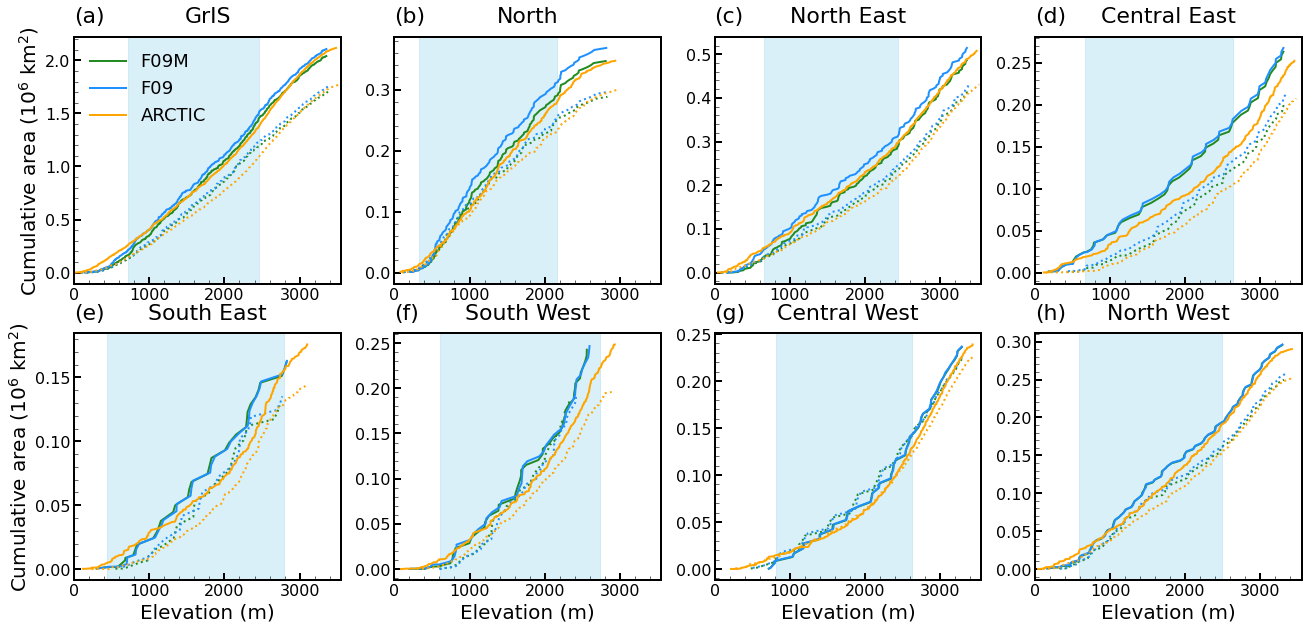

In [61]:
# Interpolate method (length weighted)
fig = plt.figure(figsize = (22,10))
gs=GridSpec(2,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2

#-------------------------------------------- 1 --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.axvspan(ARCTIC_ela_GrIS_ah_sqrt_min, ARCTIC_ela_GrIS_ah_sqrt_max, alpha=0.3, color='skyblue')
ax1.plot(f09_elev_PI.sortby(f09_elev_PI), f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax1.plot(f09_elev_end.sortby(f09_elev_end), f09_area_accum_end.sortby(f09_area_accum_end)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax1.plot(f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax1.plot(f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax1.plot(ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax1.plot(ARCTIC_elev_end.sortby(ARCTIC_elev_end), ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax1.set_xlim([0, 3550])
ax1.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.title('(a)', fontsize=22, loc='left')
plt.title('GrIS', fontsize=22, loc='center')

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- 2 --------------------------------------------
ax2 = plt.subplot(gs[1])

ax2.axvspan(ARCTIC_ela_GrIS_b1_ah_sqrt_min, ARCTIC_ela_GrIS_b1_ah_sqrt_max, alpha=0.3, color='skyblue')
ax2.plot(f09_elev_PI_NO.sortby(f09_elev_PI_NO), f09_area_accum_PI_NO.sortby(f09_area_accum_PI_NO)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax2.plot(f09_elev_end_NO.sortby(f09_elev_end_NO), f09_area_accum_end_NO.sortby(f09_area_accum_end_NO)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax2.plot(f09_nohacks_elev_PI_NO.sortby(f09_nohacks_elev_PI_NO), f09_nohacks_area_accum_PI_NO.sortby(f09_nohacks_area_accum_PI_NO)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax2.plot(f09_nohacks_elev_end_NO.sortby(f09_nohacks_elev_end_NO), f09_nohacks_area_accum_end_NO.sortby(f09_nohacks_area_accum_end_NO)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax2.plot(ARCTIC_elev_PI_NO.sortby(ARCTIC_elev_PI_NO), ARCTIC_area_accum_PI_NO.sortby(ARCTIC_area_accum_PI_NO)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax2.plot(ARCTIC_elev_end_NO.sortby(ARCTIC_elev_end_NO), ARCTIC_area_accum_end_NO.sortby(ARCTIC_area_accum_end_NO)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax2.set_xlim([0, 3550])
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.title('(b)', fontsize=22, loc='left')
plt.title('North', fontsize=22, loc='center')

#-------------------------------------------- 3 --------------------------------------------
ax3 = plt.subplot(gs[2])

ax3.axvspan(ARCTIC_ela_GrIS_b2_ah_sqrt_min, ARCTIC_ela_GrIS_b2_ah_sqrt_max, alpha=0.3, color='skyblue')
ax3.plot(f09_elev_PI_NE.sortby(f09_elev_PI_NE), f09_area_accum_PI_NE.sortby(f09_area_accum_PI_NE)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax3.plot(f09_elev_end_NE.sortby(f09_elev_end_NE), f09_area_accum_end_NE.sortby(f09_area_accum_end_NE)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax3.plot(f09_nohacks_elev_PI_NE.sortby(f09_nohacks_elev_PI_NE), f09_nohacks_area_accum_PI_NE.sortby(f09_nohacks_area_accum_PI_NE)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax3.plot(f09_nohacks_elev_end_NE.sortby(f09_nohacks_elev_end_NE), f09_nohacks_area_accum_end_NE.sortby(f09_nohacks_area_accum_end_NE)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax3.plot(ARCTIC_elev_PI_NE.sortby(ARCTIC_elev_PI_NE), ARCTIC_area_accum_PI_NE.sortby(ARCTIC_area_accum_PI_NE)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax3.plot(ARCTIC_elev_end_NE.sortby(ARCTIC_elev_end_NE), ARCTIC_area_accum_end_NE.sortby(ARCTIC_area_accum_end_NE)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax3.set_xlim([0, 3550])
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.title('(c)', fontsize=22, loc='left')
plt.title('North East', fontsize=22, loc='center')

#-------------------------------------------- 4 --------------------------------------------
ax4 = plt.subplot(gs[3])

ax4.axvspan(ARCTIC_ela_GrIS_b3_ah_sqrt_min, ARCTIC_ela_GrIS_b3_ah_sqrt_max, alpha=0.3, color='skyblue')
ax4.plot(f09_elev_PI_CE.sortby(f09_elev_PI_CE), f09_area_accum_PI_CE.sortby(f09_area_accum_PI_CE)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax4.plot(f09_elev_end_CE.sortby(f09_elev_end_CE), f09_area_accum_end_CE.sortby(f09_area_accum_end_CE)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax4.plot(f09_nohacks_elev_PI_CE.sortby(f09_nohacks_elev_PI_CE), f09_nohacks_area_accum_PI_CE.sortby(f09_nohacks_area_accum_PI_CE)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax4.plot(f09_nohacks_elev_end_CE.sortby(f09_nohacks_elev_end_CE), f09_nohacks_area_accum_end_CE.sortby(f09_nohacks_area_accum_end_CE)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax4.plot(ARCTIC_elev_PI_CE.sortby(ARCTIC_elev_PI_CE), ARCTIC_area_accum_PI_CE.sortby(ARCTIC_area_accum_PI_CE)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax4.plot(ARCTIC_elev_end_CE.sortby(ARCTIC_elev_end_CE), ARCTIC_area_accum_end_CE.sortby(ARCTIC_area_accum_end_CE)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax4.set_xlim([0, 3550])
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)
plt.title('(d)', fontsize=22, loc='left')
plt.title('Central East', fontsize=22, loc='center')

#-------------------------------------------- 5 --------------------------------------------
ax5 = plt.subplot(gs[4])

ax5.axvspan(ARCTIC_ela_GrIS_b4_ah_sqrt_min, ARCTIC_ela_GrIS_b4_ah_sqrt_max, alpha=0.3, color='skyblue')
ax5.plot(f09_elev_PI_SE.sortby(f09_elev_PI_SE), f09_area_accum_PI_SE.sortby(f09_area_accum_PI_SE)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax5.plot(f09_elev_end_SE.sortby(f09_elev_end_SE), f09_area_accum_end_SE.sortby(f09_area_accum_end_SE)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax5.plot(f09_nohacks_elev_PI_SE.sortby(f09_nohacks_elev_PI_SE), f09_nohacks_area_accum_PI_SE.sortby(f09_nohacks_area_accum_PI_SE)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax5.plot(f09_nohacks_elev_end_SE.sortby(f09_nohacks_elev_end_SE), f09_nohacks_area_accum_end_SE.sortby(f09_nohacks_area_accum_end_SE)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax5.plot(ARCTIC_elev_PI_SE.sortby(ARCTIC_elev_PI_SE), ARCTIC_area_accum_PI_SE.sortby(ARCTIC_area_accum_PI_SE)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax5.plot(ARCTIC_elev_end_SE.sortby(ARCTIC_elev_end_SE), ARCTIC_area_accum_end_SE.sortby(ARCTIC_area_accum_end_SE)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax5.set_xlim([0, 3550])
ax5.set_xlabel('Elevation (m)', fontsize=size_label)
ax5.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which='major', length=7, width=2, direction='in')
ax5.tick_params(which='minor', length=4, direction='in')
ax5.tick_params(labelsize=size_tick)
plt.title('(e)', fontsize=22, loc='left')
plt.title('South East', fontsize=22, loc='center')

#-------------------------------------------- 6 --------------------------------------------
ax6 = plt.subplot(gs[5])

ax6.axvspan(ARCTIC_ela_GrIS_b5_ah_sqrt_min, ARCTIC_ela_GrIS_b5_ah_sqrt_max, alpha=0.3, color='skyblue')
ax6.plot(f09_elev_PI_SW.sortby(f09_elev_PI_SW), f09_area_accum_PI_SW.sortby(f09_area_accum_PI_SW)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax6.plot(f09_elev_end_SW.sortby(f09_elev_end_SW), f09_area_accum_end_SW.sortby(f09_area_accum_end_SW)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax6.plot(f09_nohacks_elev_PI_SW.sortby(f09_nohacks_elev_PI_SW), f09_nohacks_area_accum_PI_SW.sortby(f09_nohacks_area_accum_PI_SW)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax6.plot(f09_nohacks_elev_end_SW.sortby(f09_nohacks_elev_end_SW), f09_nohacks_area_accum_end_SW.sortby(f09_nohacks_area_accum_end_SW)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax6.plot(ARCTIC_elev_PI_SW.sortby(ARCTIC_elev_PI_SW), ARCTIC_area_accum_PI_SW.sortby(ARCTIC_area_accum_PI_SW)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax6.plot(ARCTIC_elev_end_SW.sortby(ARCTIC_elev_end_SW), ARCTIC_area_accum_end_SW.sortby(ARCTIC_area_accum_end_SW)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax6.set_xlim([0, 3550])
ax6.set_xlabel('Elevation (m)', fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which='major', length=7, width=2, direction='in')
ax6.tick_params(which='minor', length=4, direction='in')
ax6.tick_params(labelsize=size_tick)
plt.title('(f)', fontsize=22, loc='left')
plt.title('South West', fontsize=22, loc='center')

#-------------------------------------------- 7 --------------------------------------------
ax7 = plt.subplot(gs[6])

ax7.axvspan(ARCTIC_ela_GrIS_b6_ah_sqrt_min, ARCTIC_ela_GrIS_b6_ah_sqrt_max, alpha=0.3, color='skyblue')
ax7.plot(f09_elev_PI_CW.sortby(f09_elev_PI_CW), f09_area_accum_PI_CW.sortby(f09_area_accum_PI_CW)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax7.plot(f09_elev_end_CW.sortby(f09_elev_end_CW), f09_area_accum_end_CW.sortby(f09_area_accum_end_CW)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax7.plot(f09_nohacks_elev_PI_CW.sortby(f09_nohacks_elev_PI_CW), f09_nohacks_area_accum_PI_CW.sortby(f09_nohacks_area_accum_PI_CW)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax7.plot(f09_nohacks_elev_end_CW.sortby(f09_nohacks_elev_end_CW), f09_nohacks_area_accum_end_CW.sortby(f09_nohacks_area_accum_end_CW)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax7.plot(ARCTIC_elev_PI_CW.sortby(ARCTIC_elev_PI_CW), ARCTIC_area_accum_PI_CW.sortby(ARCTIC_area_accum_PI_CW)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax7.plot(ARCTIC_elev_end_CW.sortby(ARCTIC_elev_end_CW), ARCTIC_area_accum_end_CW.sortby(ARCTIC_area_accum_end_CW)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax7.set_xlim([0, 3550])
ax7.set_xlabel('Elevation (m)', fontsize=size_label)
ax7.xaxis.set_minor_locator(AutoMinorLocator())
ax7.yaxis.set_minor_locator(AutoMinorLocator())
ax7.tick_params(which='major', length=7, width=2, direction='in')
ax7.tick_params(which='minor', length=4, direction='in')
ax7.tick_params(labelsize=size_tick)
plt.title('(g)', fontsize=22, loc='left')
plt.title('Central West', fontsize=22, loc='center')

#-------------------------------------------- 8 --------------------------------------------
ax8 = plt.subplot(gs[7])

ax8.axvspan(ARCTIC_ela_GrIS_b7_ah_sqrt_min, ARCTIC_ela_GrIS_b7_ah_sqrt_max, alpha=0.3, color='skyblue')
ax8.plot(f09_elev_PI_NW.sortby(f09_elev_PI_NW), f09_area_accum_PI_NW.sortby(f09_area_accum_PI_NW)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax8.plot(f09_elev_end_NW.sortby(f09_elev_end_NW), f09_area_accum_end_NW.sortby(f09_area_accum_end_NW)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax8.plot(f09_nohacks_elev_PI_NW.sortby(f09_nohacks_elev_PI_NW), f09_nohacks_area_accum_PI_NW.sortby(f09_nohacks_area_accum_PI_NW)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax8.plot(f09_nohacks_elev_end_NW.sortby(f09_nohacks_elev_end_NW), f09_nohacks_area_accum_end_NW.sortby(f09_nohacks_area_accum_end_NW)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax8.plot(ARCTIC_elev_PI_NW.sortby(ARCTIC_elev_PI_NW), ARCTIC_area_accum_PI_NW.sortby(ARCTIC_area_accum_PI_NW)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax8.plot(ARCTIC_elev_end_NW.sortby(ARCTIC_elev_end_NW), ARCTIC_area_accum_end_NW.sortby(ARCTIC_area_accum_end_NW)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax8.set_xlim([0, 3550])
ax8.set_xlabel('Elevation (m)', fontsize=size_label)
ax8.xaxis.set_minor_locator(AutoMinorLocator())
ax8.yaxis.set_minor_locator(AutoMinorLocator())
ax8.tick_params(which='major', length=7, width=2, direction='in')
ax8.tick_params(which='minor', length=4, direction='in')
ax8.tick_params(labelsize=size_tick)
plt.title('(h)', fontsize=22, loc='left')
plt.title('North West', fontsize=22, loc='center')


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Elevation_area_basins.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

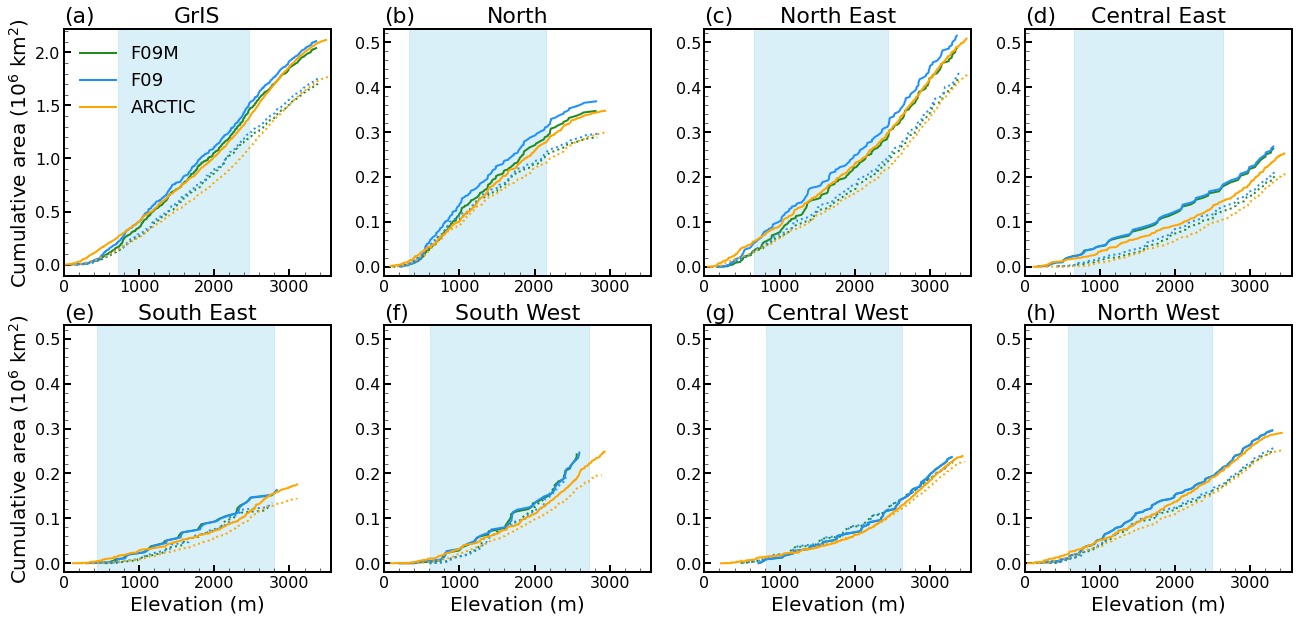

In [32]:
# Interpolate method (length weighted)
# same y axis for basins
fig = plt.figure(figsize = (22,10))
gs=GridSpec(2,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2
yrange = [-0.02, 0.53]

#-------------------------------------------- 1 --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.axvspan(ARCTIC_ela_GrIS_ah_sqrt_min, ARCTIC_ela_GrIS_ah_sqrt_max, alpha=0.3, color='skyblue')
#plt.axvline(x=ARCTIC_ela_GrIS_ah_sqrt_min, color='gray', linewidth=line_width-1)
#plt.axvline(x=ARCTIC_ela_GrIS_ah_sqrt_max, color='k', linewidth=line_width-1)
ax1.plot(f09_elev_PI.sortby(f09_elev_PI), f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax1.plot(f09_elev_end.sortby(f09_elev_end), f09_area_accum_end.sortby(f09_area_accum_end)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax1.plot(f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax1.plot(f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax1.plot(ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax1.plot(ARCTIC_elev_end.sortby(ARCTIC_elev_end), ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax1.set_xlim([0, 3550])
#ax1.set_ylim(yrange)
#ax1.set_xlabel('Elevation (m)', fontsize=size_label)
ax1.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
#ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)
plt.title('(a)', fontsize=22, loc='left')
plt.title('GrIS', fontsize=22, loc='center')

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- 2 --------------------------------------------
ax2 = plt.subplot(gs[1])

ax2.axvspan(ARCTIC_ela_GrIS_b1_ah_sqrt_min, ARCTIC_ela_GrIS_b1_ah_sqrt_max, alpha=0.3, color='skyblue')
ax2.plot(f09_elev_PI_NO.sortby(f09_elev_PI_NO), f09_area_accum_PI_NO.sortby(f09_area_accum_PI_NO)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax2.plot(f09_elev_end_NO.sortby(f09_elev_end_NO), f09_area_accum_end_NO.sortby(f09_area_accum_end_NO)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax2.plot(f09_nohacks_elev_PI_NO.sortby(f09_nohacks_elev_PI_NO), f09_nohacks_area_accum_PI_NO.sortby(f09_nohacks_area_accum_PI_NO)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax2.plot(f09_nohacks_elev_end_NO.sortby(f09_nohacks_elev_end_NO), f09_nohacks_area_accum_end_NO.sortby(f09_nohacks_area_accum_end_NO)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax2.plot(ARCTIC_elev_PI_NO.sortby(ARCTIC_elev_PI_NO), ARCTIC_area_accum_PI_NO.sortby(ARCTIC_area_accum_PI_NO)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax2.plot(ARCTIC_elev_end_NO.sortby(ARCTIC_elev_end_NO), ARCTIC_area_accum_end_NO.sortby(ARCTIC_area_accum_end_NO)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax2.set_xlim([0, 3550])
ax2.set_ylim(yrange)
#ax2.set_xlabel('Elevation (m)', fontsize=size_label)
#ax2.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
#ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)
plt.title('(b)', fontsize=22, loc='left')
plt.title('North', fontsize=22, loc='center')

#-------------------------------------------- 3 --------------------------------------------
ax3 = plt.subplot(gs[2])

ax3.axvspan(ARCTIC_ela_GrIS_b2_ah_sqrt_min, ARCTIC_ela_GrIS_b2_ah_sqrt_max, alpha=0.3, color='skyblue')
ax3.plot(f09_elev_PI_NE.sortby(f09_elev_PI_NE), f09_area_accum_PI_NE.sortby(f09_area_accum_PI_NE)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax3.plot(f09_elev_end_NE.sortby(f09_elev_end_NE), f09_area_accum_end_NE.sortby(f09_area_accum_end_NE)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax3.plot(f09_nohacks_elev_PI_NE.sortby(f09_nohacks_elev_PI_NE), f09_nohacks_area_accum_PI_NE.sortby(f09_nohacks_area_accum_PI_NE)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax3.plot(f09_nohacks_elev_end_NE.sortby(f09_nohacks_elev_end_NE), f09_nohacks_area_accum_end_NE.sortby(f09_nohacks_area_accum_end_NE)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax3.plot(ARCTIC_elev_PI_NE.sortby(ARCTIC_elev_PI_NE), ARCTIC_area_accum_PI_NE.sortby(ARCTIC_area_accum_PI_NE)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax3.plot(ARCTIC_elev_end_NE.sortby(ARCTIC_elev_end_NE), ARCTIC_area_accum_end_NE.sortby(ARCTIC_area_accum_end_NE)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax3.set_xlim([0, 3550])
ax3.set_ylim(yrange)
#ax3.set_xlabel('Elevation (m)', fontsize=size_label)
#ax3.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.title('(c)', fontsize=22, loc='left')
plt.title('North East', fontsize=22, loc='center')

#-------------------------------------------- 4 --------------------------------------------
ax4 = plt.subplot(gs[3])

ax4.axvspan(ARCTIC_ela_GrIS_b3_ah_sqrt_min, ARCTIC_ela_GrIS_b3_ah_sqrt_max, alpha=0.3, color='skyblue')
ax4.plot(f09_elev_PI_CE.sortby(f09_elev_PI_CE), f09_area_accum_PI_CE.sortby(f09_area_accum_PI_CE)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax4.plot(f09_elev_end_CE.sortby(f09_elev_end_CE), f09_area_accum_end_CE.sortby(f09_area_accum_end_CE)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax4.plot(f09_nohacks_elev_PI_CE.sortby(f09_nohacks_elev_PI_CE), f09_nohacks_area_accum_PI_CE.sortby(f09_nohacks_area_accum_PI_CE)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax4.plot(f09_nohacks_elev_end_CE.sortby(f09_nohacks_elev_end_CE), f09_nohacks_area_accum_end_CE.sortby(f09_nohacks_area_accum_end_CE)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax4.plot(ARCTIC_elev_PI_CE.sortby(ARCTIC_elev_PI_CE), ARCTIC_area_accum_PI_CE.sortby(ARCTIC_area_accum_PI_CE)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax4.plot(ARCTIC_elev_end_CE.sortby(ARCTIC_elev_end_CE), ARCTIC_area_accum_end_CE.sortby(ARCTIC_area_accum_end_CE)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax4.set_xlim([0, 3550])
ax4.set_ylim(yrange)
#ax4.set_xlabel('Elevation (m)', fontsize=size_label)
#ax4.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)
plt.title('(d)', fontsize=22, loc='left')
plt.title('Central East', fontsize=22, loc='center')

#-------------------------------------------- 5 --------------------------------------------
ax5 = plt.subplot(gs[4])

ax5.axvspan(ARCTIC_ela_GrIS_b4_ah_sqrt_min, ARCTIC_ela_GrIS_b4_ah_sqrt_max, alpha=0.3, color='skyblue')
ax5.plot(f09_elev_PI_SE.sortby(f09_elev_PI_SE), f09_area_accum_PI_SE.sortby(f09_area_accum_PI_SE)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax5.plot(f09_elev_end_SE.sortby(f09_elev_end_SE), f09_area_accum_end_SE.sortby(f09_area_accum_end_SE)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax5.plot(f09_nohacks_elev_PI_SE.sortby(f09_nohacks_elev_PI_SE), f09_nohacks_area_accum_PI_SE.sortby(f09_nohacks_area_accum_PI_SE)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax5.plot(f09_nohacks_elev_end_SE.sortby(f09_nohacks_elev_end_SE), f09_nohacks_area_accum_end_SE.sortby(f09_nohacks_area_accum_end_SE)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax5.plot(ARCTIC_elev_PI_SE.sortby(ARCTIC_elev_PI_SE), ARCTIC_area_accum_PI_SE.sortby(ARCTIC_area_accum_PI_SE)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax5.plot(ARCTIC_elev_end_SE.sortby(ARCTIC_elev_end_SE), ARCTIC_area_accum_end_SE.sortby(ARCTIC_area_accum_end_SE)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax5.set_xlim([0, 3550])
ax5.set_ylim(yrange)
ax5.set_xlabel('Elevation (m)', fontsize=size_label)
ax5.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which='major', length=7, width=2, direction='in')
ax5.tick_params(which='minor', length=4, direction='in')
ax5.tick_params(labelsize=size_tick)
plt.title('(e)', fontsize=22, loc='left')
plt.title('South East', fontsize=22, loc='center')

#-------------------------------------------- 6 --------------------------------------------
ax6 = plt.subplot(gs[5])

ax6.axvspan(ARCTIC_ela_GrIS_b5_ah_sqrt_min, ARCTIC_ela_GrIS_b5_ah_sqrt_max, alpha=0.3, color='skyblue')
ax6.plot(f09_elev_PI_SW.sortby(f09_elev_PI_SW), f09_area_accum_PI_SW.sortby(f09_area_accum_PI_SW)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax6.plot(f09_elev_end_SW.sortby(f09_elev_end_SW), f09_area_accum_end_SW.sortby(f09_area_accum_end_SW)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax6.plot(f09_nohacks_elev_PI_SW.sortby(f09_nohacks_elev_PI_SW), f09_nohacks_area_accum_PI_SW.sortby(f09_nohacks_area_accum_PI_SW)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax6.plot(f09_nohacks_elev_end_SW.sortby(f09_nohacks_elev_end_SW), f09_nohacks_area_accum_end_SW.sortby(f09_nohacks_area_accum_end_SW)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax6.plot(ARCTIC_elev_PI_SW.sortby(ARCTIC_elev_PI_SW), ARCTIC_area_accum_PI_SW.sortby(ARCTIC_area_accum_PI_SW)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax6.plot(ARCTIC_elev_end_SW.sortby(ARCTIC_elev_end_SW), ARCTIC_area_accum_end_SW.sortby(ARCTIC_area_accum_end_SW)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax6.set_xlim([0, 3550])
ax6.set_ylim(yrange)
ax6.set_xlabel('Elevation (m)', fontsize=size_label)
#ax6.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which='major', length=7, width=2, direction='in')
ax6.tick_params(which='minor', length=4, direction='in')
ax6.tick_params(labelsize=size_tick)
plt.title('(f)', fontsize=22, loc='left')
plt.title('South West', fontsize=22, loc='center')

#-------------------------------------------- 7 --------------------------------------------
ax7 = plt.subplot(gs[6])

ax7.axvspan(ARCTIC_ela_GrIS_b6_ah_sqrt_min, ARCTIC_ela_GrIS_b6_ah_sqrt_max, alpha=0.3, color='skyblue')
ax7.plot(f09_elev_PI_CW.sortby(f09_elev_PI_CW), f09_area_accum_PI_CW.sortby(f09_area_accum_PI_CW)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax7.plot(f09_elev_end_CW.sortby(f09_elev_end_CW), f09_area_accum_end_CW.sortby(f09_area_accum_end_CW)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax7.plot(f09_nohacks_elev_PI_CW.sortby(f09_nohacks_elev_PI_CW), f09_nohacks_area_accum_PI_CW.sortby(f09_nohacks_area_accum_PI_CW)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax7.plot(f09_nohacks_elev_end_CW.sortby(f09_nohacks_elev_end_CW), f09_nohacks_area_accum_end_CW.sortby(f09_nohacks_area_accum_end_CW)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax7.plot(ARCTIC_elev_PI_CW.sortby(ARCTIC_elev_PI_CW), ARCTIC_area_accum_PI_CW.sortby(ARCTIC_area_accum_PI_CW)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax7.plot(ARCTIC_elev_end_CW.sortby(ARCTIC_elev_end_CW), ARCTIC_area_accum_end_CW.sortby(ARCTIC_area_accum_end_CW)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax7.set_xlim([0, 3550])
ax7.set_ylim(yrange)
ax7.set_xlabel('Elevation (m)', fontsize=size_label)
#ax7.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax7.xaxis.set_minor_locator(AutoMinorLocator())
ax7.yaxis.set_minor_locator(AutoMinorLocator())
ax7.tick_params(which='major', length=7, width=2, direction='in')
ax7.tick_params(which='minor', length=4, direction='in')
ax7.tick_params(labelsize=size_tick)
plt.title('(g)', fontsize=22, loc='left')
plt.title('Central West', fontsize=22, loc='center')

#-------------------------------------------- 8 --------------------------------------------
ax8 = plt.subplot(gs[7])

ax8.axvspan(ARCTIC_ela_GrIS_b7_ah_sqrt_min, ARCTIC_ela_GrIS_b7_ah_sqrt_max, alpha=0.3, color='skyblue')
ax8.plot(f09_elev_PI_NW.sortby(f09_elev_PI_NW), f09_area_accum_PI_NW.sortby(f09_area_accum_PI_NW)/1e12, color = 'forestgreen', linewidth = line_width, label='F09M');
ax8.plot(f09_elev_end_NW.sortby(f09_elev_end_NW), f09_area_accum_end_NW.sortby(f09_area_accum_end_NW)/1e12, color = 'forestgreen', linewidth = line_width, linestyle=':');
ax8.plot(f09_nohacks_elev_PI_NW.sortby(f09_nohacks_elev_PI_NW), f09_nohacks_area_accum_PI_NW.sortby(f09_nohacks_area_accum_PI_NW)/1e12, color = 'dodgerblue', linewidth = line_width, label='F09');
ax8.plot(f09_nohacks_elev_end_NW.sortby(f09_nohacks_elev_end_NW), f09_nohacks_area_accum_end_NW.sortby(f09_nohacks_area_accum_end_NW)/1e12, color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax8.plot(ARCTIC_elev_PI_NW.sortby(ARCTIC_elev_PI_NW), ARCTIC_area_accum_PI_NW.sortby(ARCTIC_area_accum_PI_NW)/1e12, color = 'orange', linewidth = line_width, label='ARCTIC');
ax8.plot(ARCTIC_elev_end_NW.sortby(ARCTIC_elev_end_NW), ARCTIC_area_accum_end_NW.sortby(ARCTIC_area_accum_end_NW)/1e12, color = 'orange', linewidth = line_width, linestyle=':');

ax8.set_xlim([0, 3550])
ax8.set_ylim(yrange)
ax8.set_xlabel('Elevation (m)', fontsize=size_label)
#ax8.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax8.xaxis.set_minor_locator(AutoMinorLocator())
ax8.yaxis.set_minor_locator(AutoMinorLocator())
ax8.tick_params(which='major', length=7, width=2, direction='in')
ax8.tick_params(which='minor', length=4, direction='in')
ax8.tick_params(labelsize=size_tick)
plt.title('(h)', fontsize=22, loc='left')
plt.title('North West', fontsize=22, loc='center')


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Elevation_area_basins_samey.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

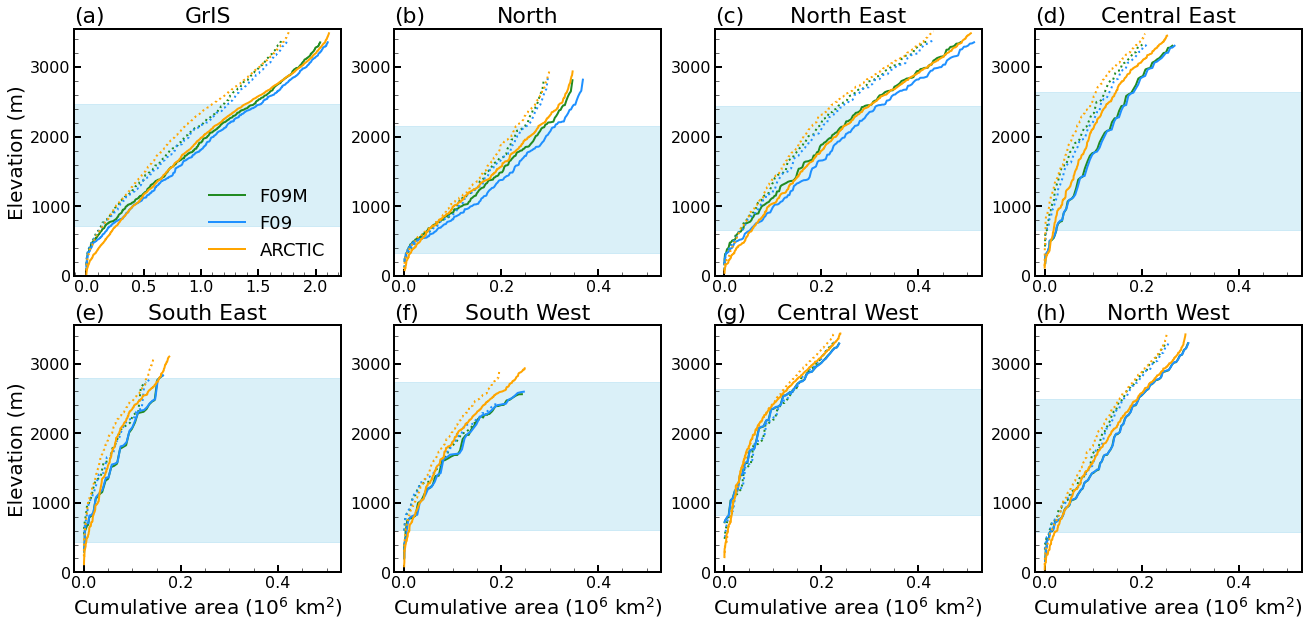

In [37]:
# Interpolate method (length weighted)
# same area range for basins, flip x, y axis
fig = plt.figure(figsize = (22,10))
gs=GridSpec(2,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2
xrange = [-0.02, 0.53]

#-------------------------------------------- 1 --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.axhspan(ARCTIC_ela_GrIS_ah_sqrt_min, ARCTIC_ela_GrIS_ah_sqrt_max, alpha=0.3, color='skyblue')
ax1.plot(f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, f09_elev_PI.sortby(f09_elev_PI), color = 'forestgreen', linewidth = line_width, label='F09M');
ax1.plot(f09_area_accum_end.sortby(f09_area_accum_end)/1e12, f09_elev_end.sortby(f09_elev_end), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax1.plot(f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), color = 'dodgerblue', linewidth = line_width, label='F09');
ax1.plot(f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax1.plot(ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), color = 'orange', linewidth = line_width, label='ARCTIC');
ax1.plot(ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, ARCTIC_elev_end.sortby(ARCTIC_elev_end), color = 'orange', linewidth = line_width, linestyle=':');

ax1.set_ylim([0, 3550])
#ax1.set_ylim(yrange)
ax1.set_ylabel('Elevation (m)', fontsize=size_label)
#ax1.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
#ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)
plt.title('(a)', fontsize=22, loc='left')
plt.title('GrIS', fontsize=22, loc='center')

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- 2 --------------------------------------------
ax2 = plt.subplot(gs[1])

ax2.axhspan(ARCTIC_ela_GrIS_b1_ah_sqrt_min, ARCTIC_ela_GrIS_b1_ah_sqrt_max, alpha=0.3, color='skyblue')
ax2.plot(f09_area_accum_PI_NO.sortby(f09_area_accum_PI_NO)/1e12, f09_elev_PI_NO.sortby(f09_elev_PI_NO), color = 'forestgreen', linewidth = line_width, label='F09M');
ax2.plot(f09_area_accum_end_NO.sortby(f09_area_accum_end_NO)/1e12, f09_elev_end_NO.sortby(f09_elev_end_NO), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax2.plot(f09_nohacks_area_accum_PI_NO.sortby(f09_nohacks_area_accum_PI_NO)/1e12, f09_nohacks_elev_PI_NO.sortby(f09_nohacks_elev_PI_NO), color = 'dodgerblue', linewidth = line_width, label='F09');
ax2.plot(f09_nohacks_area_accum_end_NO.sortby(f09_nohacks_area_accum_end_NO)/1e12, f09_nohacks_elev_end_NO.sortby(f09_nohacks_elev_end_NO), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax2.plot(ARCTIC_area_accum_PI_NO.sortby(ARCTIC_area_accum_PI_NO)/1e12, ARCTIC_elev_PI_NO.sortby(ARCTIC_elev_PI_NO), color = 'orange', linewidth = line_width, label='ARCTIC');
ax2.plot(ARCTIC_area_accum_end_NO.sortby(ARCTIC_area_accum_end_NO)/1e12, ARCTIC_elev_end_NO.sortby(ARCTIC_elev_end_NO), color = 'orange', linewidth = line_width, linestyle=':');

ax2.set_ylim([0, 3550])
ax2.set_xlim(xrange)
#ax2.set_xlabel('Elevation (m)', fontsize=size_label)
#ax2.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
#ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)
plt.title('(b)', fontsize=22, loc='left')
plt.title('North', fontsize=22, loc='center')

#-------------------------------------------- 3 --------------------------------------------
ax3 = plt.subplot(gs[2])

ax3.axhspan(ARCTIC_ela_GrIS_b2_ah_sqrt_min, ARCTIC_ela_GrIS_b2_ah_sqrt_max, alpha=0.3, color='skyblue')
ax3.plot(f09_area_accum_PI_NE.sortby(f09_area_accum_PI_NE)/1e12, f09_elev_PI_NE.sortby(f09_elev_PI_NE), color = 'forestgreen', linewidth = line_width, label='F09M');
ax3.plot(f09_area_accum_end_NE.sortby(f09_area_accum_end_NE)/1e12, f09_elev_end_NE.sortby(f09_elev_end_NE), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax3.plot(f09_nohacks_area_accum_PI_NE.sortby(f09_nohacks_area_accum_PI_NE)/1e12, f09_nohacks_elev_PI_NE.sortby(f09_nohacks_elev_PI_NE), color = 'dodgerblue', linewidth = line_width, label='F09');
ax3.plot(f09_nohacks_area_accum_end_NE.sortby(f09_nohacks_area_accum_end_NE)/1e12, f09_nohacks_elev_end_NE.sortby(f09_nohacks_elev_end_NE), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax3.plot(ARCTIC_area_accum_PI_NE.sortby(ARCTIC_area_accum_PI_NE)/1e12, ARCTIC_elev_PI_NE.sortby(ARCTIC_elev_PI_NE), color = 'orange', linewidth = line_width, label='ARCTIC');
ax3.plot(ARCTIC_area_accum_end_NE.sortby(ARCTIC_area_accum_end_NE)/1e12, ARCTIC_elev_end_NE.sortby(ARCTIC_elev_end_NE), color = 'orange', linewidth = line_width, linestyle=':');

ax3.set_ylim([0, 3550])
ax3.set_xlim(xrange)
#ax3.set_xlabel('Elevation (m)', fontsize=size_label)
#ax3.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.title('(c)', fontsize=22, loc='left')
plt.title('North East', fontsize=22, loc='center')

#-------------------------------------------- 4 --------------------------------------------
ax4 = plt.subplot(gs[3])

ax4.axhspan(ARCTIC_ela_GrIS_b3_ah_sqrt_min, ARCTIC_ela_GrIS_b3_ah_sqrt_max, alpha=0.3, color='skyblue')
ax4.plot(f09_area_accum_PI_CE.sortby(f09_area_accum_PI_CE)/1e12, f09_elev_PI_CE.sortby(f09_elev_PI_CE), color = 'forestgreen', linewidth = line_width, label='F09M');
ax4.plot(f09_area_accum_end_CE.sortby(f09_area_accum_end_CE)/1e12, f09_elev_end_CE.sortby(f09_elev_end_CE), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax4.plot(f09_nohacks_area_accum_PI_CE.sortby(f09_nohacks_area_accum_PI_CE)/1e12, f09_nohacks_elev_PI_CE.sortby(f09_nohacks_elev_PI_CE), color = 'dodgerblue', linewidth = line_width, label='F09');
ax4.plot(f09_nohacks_area_accum_end_CE.sortby(f09_nohacks_area_accum_end_CE)/1e12, f09_nohacks_elev_end_CE.sortby(f09_nohacks_elev_end_CE), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax4.plot(ARCTIC_area_accum_PI_CE.sortby(ARCTIC_area_accum_PI_CE)/1e12, ARCTIC_elev_PI_CE.sortby(ARCTIC_elev_PI_CE), color = 'orange', linewidth = line_width, label='ARCTIC');
ax4.plot(ARCTIC_area_accum_end_CE.sortby(ARCTIC_area_accum_end_CE)/1e12, ARCTIC_elev_end_CE.sortby(ARCTIC_elev_end_CE), color = 'orange', linewidth = line_width, linestyle=':');

ax4.set_ylim([0, 3550])
ax4.set_xlim(xrange)
#ax4.set_xlabel('Elevation (m)', fontsize=size_label)
#ax4.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)
plt.title('(d)', fontsize=22, loc='left')
plt.title('Central East', fontsize=22, loc='center')

#-------------------------------------------- 5 --------------------------------------------
ax5 = plt.subplot(gs[4])

ax5.axhspan(ARCTIC_ela_GrIS_b4_ah_sqrt_min, ARCTIC_ela_GrIS_b4_ah_sqrt_max, alpha=0.3, color='skyblue')
ax5.plot(f09_area_accum_PI_SE.sortby(f09_area_accum_PI_SE)/1e12, f09_elev_PI_SE.sortby(f09_elev_PI_SE), color = 'forestgreen', linewidth = line_width, label='F09M');
ax5.plot(f09_area_accum_end_SE.sortby(f09_area_accum_end_SE)/1e12, f09_elev_end_SE.sortby(f09_elev_end_SE), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax5.plot(f09_nohacks_area_accum_PI_SE.sortby(f09_nohacks_area_accum_PI_SE)/1e12, f09_nohacks_elev_PI_SE.sortby(f09_nohacks_elev_PI_SE), color = 'dodgerblue', linewidth = line_width, label='F09');
ax5.plot(f09_nohacks_area_accum_end_SE.sortby(f09_nohacks_area_accum_end_SE)/1e12, f09_nohacks_elev_end_SE.sortby(f09_nohacks_elev_end_SE), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax5.plot(ARCTIC_area_accum_PI_SE.sortby(ARCTIC_area_accum_PI_SE)/1e12, ARCTIC_elev_PI_SE.sortby(ARCTIC_elev_PI_SE), color = 'orange', linewidth = line_width, label='ARCTIC');
ax5.plot(ARCTIC_area_accum_end_SE.sortby(ARCTIC_area_accum_end_SE)/1e12, ARCTIC_elev_end_SE.sortby(ARCTIC_elev_end_SE), color = 'orange', linewidth = line_width, linestyle=':');

ax5.set_ylim([0, 3550])
ax5.set_xlim(xrange)
ax5.set_ylabel('Elevation (m)', fontsize=size_label)
ax5.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which='major', length=7, width=2, direction='in')
ax5.tick_params(which='minor', length=4, direction='in')
ax5.tick_params(labelsize=size_tick)
plt.title('(e)', fontsize=22, loc='left')
plt.title('South East', fontsize=22, loc='center')

#-------------------------------------------- 6 --------------------------------------------
ax6 = plt.subplot(gs[5])

ax6.axhspan(ARCTIC_ela_GrIS_b5_ah_sqrt_min, ARCTIC_ela_GrIS_b5_ah_sqrt_max, alpha=0.3, color='skyblue')
ax6.plot(f09_area_accum_PI_SW.sortby(f09_area_accum_PI_SW)/1e12, f09_elev_PI_SW.sortby(f09_elev_PI_SW), color = 'forestgreen', linewidth = line_width, label='F09M');
ax6.plot(f09_area_accum_end_SW.sortby(f09_area_accum_end_SW)/1e12, f09_elev_end_SW.sortby(f09_elev_end_SW), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax6.plot(f09_nohacks_area_accum_PI_SW.sortby(f09_nohacks_area_accum_PI_SW)/1e12, f09_nohacks_elev_PI_SW.sortby(f09_nohacks_elev_PI_SW), color = 'dodgerblue', linewidth = line_width, label='F09');
ax6.plot(f09_nohacks_area_accum_end_SW.sortby(f09_nohacks_area_accum_end_SW)/1e12, f09_nohacks_elev_end_SW.sortby(f09_nohacks_elev_end_SW), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax6.plot(ARCTIC_area_accum_PI_SW.sortby(ARCTIC_area_accum_PI_SW)/1e12, ARCTIC_elev_PI_SW.sortby(ARCTIC_elev_PI_SW), color = 'orange', linewidth = line_width, label='ARCTIC');
ax6.plot(ARCTIC_area_accum_end_SW.sortby(ARCTIC_area_accum_end_SW)/1e12, ARCTIC_elev_end_SW.sortby(ARCTIC_elev_end_SW), color = 'orange', linewidth = line_width, linestyle=':');

ax6.set_ylim([0, 3550])
ax6.set_xlim(xrange)
#ax6.set_ylabel('Elevation (m)', fontsize=size_label)
ax6.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which='major', length=7, width=2, direction='in')
ax6.tick_params(which='minor', length=4, direction='in')
ax6.tick_params(labelsize=size_tick)
plt.title('(f)', fontsize=22, loc='left')
plt.title('South West', fontsize=22, loc='center')

#-------------------------------------------- 7 --------------------------------------------
ax7 = plt.subplot(gs[6])

ax7.axhspan(ARCTIC_ela_GrIS_b6_ah_sqrt_min, ARCTIC_ela_GrIS_b6_ah_sqrt_max, alpha=0.3, color='skyblue')
ax7.plot(f09_area_accum_PI_CW.sortby(f09_area_accum_PI_CW)/1e12, f09_elev_PI_CW.sortby(f09_elev_PI_CW), color = 'forestgreen', linewidth = line_width, label='F09M');
ax7.plot(f09_area_accum_end_CW.sortby(f09_area_accum_end_CW)/1e12, f09_elev_end_CW.sortby(f09_elev_end_CW), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax7.plot(f09_nohacks_area_accum_PI_CW.sortby(f09_nohacks_area_accum_PI_CW)/1e12, f09_nohacks_elev_PI_CW.sortby(f09_nohacks_elev_PI_CW), color = 'dodgerblue', linewidth = line_width, label='F09');
ax7.plot(f09_nohacks_area_accum_end_CW.sortby(f09_nohacks_area_accum_end_CW)/1e12, f09_nohacks_elev_end_CW.sortby(f09_nohacks_elev_end_CW), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax7.plot(ARCTIC_area_accum_PI_CW.sortby(ARCTIC_area_accum_PI_CW)/1e12, ARCTIC_elev_PI_CW.sortby(ARCTIC_elev_PI_CW), color = 'orange', linewidth = line_width, label='ARCTIC');
ax7.plot(ARCTIC_area_accum_end_CW.sortby(ARCTIC_area_accum_end_CW)/1e12, ARCTIC_elev_end_CW.sortby(ARCTIC_elev_end_CW), color = 'orange', linewidth = line_width, linestyle=':');

ax7.set_ylim([0, 3550])
ax7.set_xlim(xrange)
#ax7.set_ylabel('Elevation (m)', fontsize=size_label)
ax7.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax7.xaxis.set_minor_locator(AutoMinorLocator())
ax7.yaxis.set_minor_locator(AutoMinorLocator())
ax7.tick_params(which='major', length=7, width=2, direction='in')
ax7.tick_params(which='minor', length=4, direction='in')
ax7.tick_params(labelsize=size_tick)
plt.title('(g)', fontsize=22, loc='left')
plt.title('Central West', fontsize=22, loc='center')

#-------------------------------------------- 8 --------------------------------------------
ax8 = plt.subplot(gs[7])

ax8.axhspan(ARCTIC_ela_GrIS_b7_ah_sqrt_min, ARCTIC_ela_GrIS_b7_ah_sqrt_max, alpha=0.3, color='skyblue')
ax8.plot(f09_area_accum_PI_NW.sortby(f09_area_accum_PI_NW)/1e12, f09_elev_PI_NW.sortby(f09_elev_PI_NW), color = 'forestgreen', linewidth = line_width, label='F09M');
ax8.plot(f09_area_accum_end_NW.sortby(f09_area_accum_end_NW)/1e12, f09_elev_end_NW.sortby(f09_elev_end_NW), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax8.plot(f09_nohacks_area_accum_PI_NW.sortby(f09_nohacks_area_accum_PI_NW)/1e12, f09_nohacks_elev_PI_NW.sortby(f09_nohacks_elev_PI_NW), color = 'dodgerblue', linewidth = line_width, label='F09');
ax8.plot(f09_nohacks_area_accum_end_NW.sortby(f09_nohacks_area_accum_end_NW)/1e12, f09_nohacks_elev_end_NW.sortby(f09_nohacks_elev_end_NW), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax8.plot(ARCTIC_area_accum_PI_NW.sortby(ARCTIC_area_accum_PI_NW)/1e12, ARCTIC_elev_PI_NW.sortby(ARCTIC_elev_PI_NW), color = 'orange', linewidth = line_width, label='ARCTIC');
ax8.plot(ARCTIC_area_accum_end_NW.sortby(ARCTIC_area_accum_end_NW)/1e12, ARCTIC_elev_end_NW.sortby(ARCTIC_elev_end_NW), color = 'orange', linewidth = line_width, linestyle=':');

ax8.set_ylim([0, 3550])
ax8.set_xlim(xrange)
#ax8.set_ylabel('Elevation (m)', fontsize=size_label)
ax8.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax8.xaxis.set_minor_locator(AutoMinorLocator())
ax8.yaxis.set_minor_locator(AutoMinorLocator())
ax8.tick_params(which='major', length=7, width=2, direction='in')
ax8.tick_params(which='minor', length=4, direction='in')
ax8.tick_params(labelsize=size_tick)
plt.title('(h)', fontsize=22, loc='left')
plt.title('North West', fontsize=22, loc='center')


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Elevation_area_basins_flipxy.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

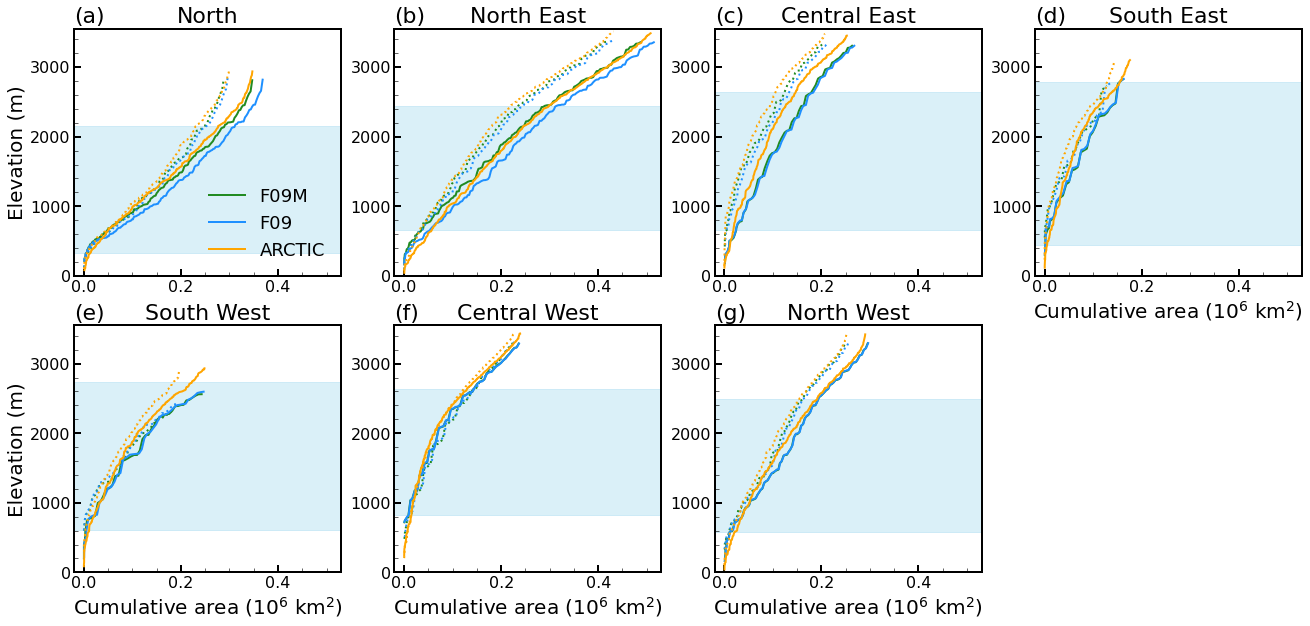

In [99]:
# Interpolate method (length weighted)
# same area range for basins, flip x, y axis
# only for basins
fig = plt.figure(figsize = (22,10))
gs=GridSpec(2,4)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2
xrange = [-0.02, 0.53]

#-------------------------------------------- 1 --------------------------------------------
#ax1 = plt.subplot(gs[0])

#ax1.axhspan(ARCTIC_ela_GrIS_ah_sqrt_min, ARCTIC_ela_GrIS_ah_sqrt_max, alpha=0.3, color='skyblue')
#ax1.plot(f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, f09_elev_PI.sortby(f09_elev_PI), color = 'forestgreen', linewidth = line_width, label='F09M');
#ax1.plot(f09_area_accum_end.sortby(f09_area_accum_end)/1e12, f09_elev_end.sortby(f09_elev_end), color = 'forestgreen', linewidth = line_width, linestyle=':');
#ax1.plot(f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), color = 'dodgerblue', linewidth = line_width, label='F09');
#ax1.plot(f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), color = 'dodgerblue', linewidth = line_width, linestyle=':');
#ax1.plot(ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), color = 'orange', linewidth = line_width, label='ARCTIC');
#ax1.plot(ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, ARCTIC_elev_end.sortby(ARCTIC_elev_end), color = 'orange', linewidth = line_width, linestyle=':');

#ax1.set_ylim([0, 3550])
#ax1.set_ylim(yrange)
#ax1.set_ylabel('Elevation (m)', fontsize=size_label)
#ax1.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
#ax1.xaxis.set_minor_locator(AutoMinorLocator())
#ax1.yaxis.set_minor_locator(AutoMinorLocator())
#ax1.tick_params(which='major', length=7, width=2, direction='in')
#ax1.tick_params(which='minor', length=4, direction='in')
#ax1.set_yticks([-1000, -500, 0, 500])
#ax1.tick_params(labelsize=size_tick)
#plt.title('(a)', fontsize=22, loc='left')
#plt.title('GrIS', fontsize=22, loc='center')

#ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- 2 --------------------------------------------
ax2 = plt.subplot(gs[0])

ax2.axhspan(ARCTIC_ela_GrIS_b1_ah_sqrt_min, ARCTIC_ela_GrIS_b1_ah_sqrt_max, alpha=0.3, color='skyblue')
ax2.plot(f09_area_accum_PI_NO.sortby(f09_area_accum_PI_NO)/1e12, f09_elev_PI_NO.sortby(f09_elev_PI_NO), color = 'forestgreen', linewidth = line_width, label='F09M');
ax2.plot(f09_area_accum_end_NO.sortby(f09_area_accum_end_NO)/1e12, f09_elev_end_NO.sortby(f09_elev_end_NO), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax2.plot(f09_nohacks_area_accum_PI_NO.sortby(f09_nohacks_area_accum_PI_NO)/1e12, f09_nohacks_elev_PI_NO.sortby(f09_nohacks_elev_PI_NO), color = 'dodgerblue', linewidth = line_width, label='F09');
ax2.plot(f09_nohacks_area_accum_end_NO.sortby(f09_nohacks_area_accum_end_NO)/1e12, f09_nohacks_elev_end_NO.sortby(f09_nohacks_elev_end_NO), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax2.plot(ARCTIC_area_accum_PI_NO.sortby(ARCTIC_area_accum_PI_NO)/1e12, ARCTIC_elev_PI_NO.sortby(ARCTIC_elev_PI_NO), color = 'orange', linewidth = line_width, label='ARCTIC');
ax2.plot(ARCTIC_area_accum_end_NO.sortby(ARCTIC_area_accum_end_NO)/1e12, ARCTIC_elev_end_NO.sortby(ARCTIC_elev_end_NO), color = 'orange', linewidth = line_width, linestyle=':');

ax2.set_ylim([0, 3550])
ax2.set_xlim(xrange)
ax2.set_ylabel('Elevation (m)', fontsize=size_label)
#ax2.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
#ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)
plt.title('(a)', fontsize=22, loc='left')
plt.title('North', fontsize=22, loc='center')

ax2.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- 3 --------------------------------------------
ax3 = plt.subplot(gs[1])

ax3.axhspan(ARCTIC_ela_GrIS_b2_ah_sqrt_min, ARCTIC_ela_GrIS_b2_ah_sqrt_max, alpha=0.3, color='skyblue')
ax3.plot(f09_area_accum_PI_NE.sortby(f09_area_accum_PI_NE)/1e12, f09_elev_PI_NE.sortby(f09_elev_PI_NE), color = 'forestgreen', linewidth = line_width, label='F09M');
ax3.plot(f09_area_accum_end_NE.sortby(f09_area_accum_end_NE)/1e12, f09_elev_end_NE.sortby(f09_elev_end_NE), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax3.plot(f09_nohacks_area_accum_PI_NE.sortby(f09_nohacks_area_accum_PI_NE)/1e12, f09_nohacks_elev_PI_NE.sortby(f09_nohacks_elev_PI_NE), color = 'dodgerblue', linewidth = line_width, label='F09');
ax3.plot(f09_nohacks_area_accum_end_NE.sortby(f09_nohacks_area_accum_end_NE)/1e12, f09_nohacks_elev_end_NE.sortby(f09_nohacks_elev_end_NE), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax3.plot(ARCTIC_area_accum_PI_NE.sortby(ARCTIC_area_accum_PI_NE)/1e12, ARCTIC_elev_PI_NE.sortby(ARCTIC_elev_PI_NE), color = 'orange', linewidth = line_width, label='ARCTIC');
ax3.plot(ARCTIC_area_accum_end_NE.sortby(ARCTIC_area_accum_end_NE)/1e12, ARCTIC_elev_end_NE.sortby(ARCTIC_elev_end_NE), color = 'orange', linewidth = line_width, linestyle=':');

ax3.set_ylim([0, 3550])
ax3.set_xlim(xrange)
#ax3.set_xlabel('Elevation (m)', fontsize=size_label)
#ax3.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.title('(b)', fontsize=22, loc='left')
plt.title('North East', fontsize=22, loc='center')

#-------------------------------------------- 4 --------------------------------------------
ax4 = plt.subplot(gs[2])

ax4.axhspan(ARCTIC_ela_GrIS_b3_ah_sqrt_min, ARCTIC_ela_GrIS_b3_ah_sqrt_max, alpha=0.3, color='skyblue')
ax4.plot(f09_area_accum_PI_CE.sortby(f09_area_accum_PI_CE)/1e12, f09_elev_PI_CE.sortby(f09_elev_PI_CE), color = 'forestgreen', linewidth = line_width, label='F09M');
ax4.plot(f09_area_accum_end_CE.sortby(f09_area_accum_end_CE)/1e12, f09_elev_end_CE.sortby(f09_elev_end_CE), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax4.plot(f09_nohacks_area_accum_PI_CE.sortby(f09_nohacks_area_accum_PI_CE)/1e12, f09_nohacks_elev_PI_CE.sortby(f09_nohacks_elev_PI_CE), color = 'dodgerblue', linewidth = line_width, label='F09');
ax4.plot(f09_nohacks_area_accum_end_CE.sortby(f09_nohacks_area_accum_end_CE)/1e12, f09_nohacks_elev_end_CE.sortby(f09_nohacks_elev_end_CE), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax4.plot(ARCTIC_area_accum_PI_CE.sortby(ARCTIC_area_accum_PI_CE)/1e12, ARCTIC_elev_PI_CE.sortby(ARCTIC_elev_PI_CE), color = 'orange', linewidth = line_width, label='ARCTIC');
ax4.plot(ARCTIC_area_accum_end_CE.sortby(ARCTIC_area_accum_end_CE)/1e12, ARCTIC_elev_end_CE.sortby(ARCTIC_elev_end_CE), color = 'orange', linewidth = line_width, linestyle=':');

ax4.set_ylim([0, 3550])
ax4.set_xlim(xrange)
#ax4.set_xlabel('Elevation (m)', fontsize=size_label)
#ax4.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)
plt.title('(c)', fontsize=22, loc='left')
plt.title('Central East', fontsize=22, loc='center')

#-------------------------------------------- 5 --------------------------------------------
ax5 = plt.subplot(gs[3])

ax5.axhspan(ARCTIC_ela_GrIS_b4_ah_sqrt_min, ARCTIC_ela_GrIS_b4_ah_sqrt_max, alpha=0.3, color='skyblue')
ax5.plot(f09_area_accum_PI_SE.sortby(f09_area_accum_PI_SE)/1e12, f09_elev_PI_SE.sortby(f09_elev_PI_SE), color = 'forestgreen', linewidth = line_width, label='F09M');
ax5.plot(f09_area_accum_end_SE.sortby(f09_area_accum_end_SE)/1e12, f09_elev_end_SE.sortby(f09_elev_end_SE), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax5.plot(f09_nohacks_area_accum_PI_SE.sortby(f09_nohacks_area_accum_PI_SE)/1e12, f09_nohacks_elev_PI_SE.sortby(f09_nohacks_elev_PI_SE), color = 'dodgerblue', linewidth = line_width, label='F09');
ax5.plot(f09_nohacks_area_accum_end_SE.sortby(f09_nohacks_area_accum_end_SE)/1e12, f09_nohacks_elev_end_SE.sortby(f09_nohacks_elev_end_SE), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax5.plot(ARCTIC_area_accum_PI_SE.sortby(ARCTIC_area_accum_PI_SE)/1e12, ARCTIC_elev_PI_SE.sortby(ARCTIC_elev_PI_SE), color = 'orange', linewidth = line_width, label='ARCTIC');
ax5.plot(ARCTIC_area_accum_end_SE.sortby(ARCTIC_area_accum_end_SE)/1e12, ARCTIC_elev_end_SE.sortby(ARCTIC_elev_end_SE), color = 'orange', linewidth = line_width, linestyle=':');

ax5.set_ylim([0, 3550])
ax5.set_xlim(xrange)
#ax5.set_ylabel('Elevation (m)', fontsize=size_label)
ax5.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax5.xaxis.set_minor_locator(AutoMinorLocator())
ax5.yaxis.set_minor_locator(AutoMinorLocator())
ax5.tick_params(which='major', length=7, width=2, direction='in')
ax5.tick_params(which='minor', length=4, direction='in')
ax5.tick_params(labelsize=size_tick)
plt.title('(d)', fontsize=22, loc='left')
plt.title('South East', fontsize=22, loc='center')

#-------------------------------------------- 6 --------------------------------------------
ax6 = plt.subplot(gs[4])

ax6.axhspan(ARCTIC_ela_GrIS_b5_ah_sqrt_min, ARCTIC_ela_GrIS_b5_ah_sqrt_max, alpha=0.3, color='skyblue')
ax6.plot(f09_area_accum_PI_SW.sortby(f09_area_accum_PI_SW)/1e12, f09_elev_PI_SW.sortby(f09_elev_PI_SW), color = 'forestgreen', linewidth = line_width, label='F09M');
ax6.plot(f09_area_accum_end_SW.sortby(f09_area_accum_end_SW)/1e12, f09_elev_end_SW.sortby(f09_elev_end_SW), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax6.plot(f09_nohacks_area_accum_PI_SW.sortby(f09_nohacks_area_accum_PI_SW)/1e12, f09_nohacks_elev_PI_SW.sortby(f09_nohacks_elev_PI_SW), color = 'dodgerblue', linewidth = line_width, label='F09');
ax6.plot(f09_nohacks_area_accum_end_SW.sortby(f09_nohacks_area_accum_end_SW)/1e12, f09_nohacks_elev_end_SW.sortby(f09_nohacks_elev_end_SW), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax6.plot(ARCTIC_area_accum_PI_SW.sortby(ARCTIC_area_accum_PI_SW)/1e12, ARCTIC_elev_PI_SW.sortby(ARCTIC_elev_PI_SW), color = 'orange', linewidth = line_width, label='ARCTIC');
ax6.plot(ARCTIC_area_accum_end_SW.sortby(ARCTIC_area_accum_end_SW)/1e12, ARCTIC_elev_end_SW.sortby(ARCTIC_elev_end_SW), color = 'orange', linewidth = line_width, linestyle=':');

ax6.set_ylim([0, 3550])
ax6.set_xlim(xrange)
ax6.set_ylabel('Elevation (m)', fontsize=size_label)
ax6.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which='major', length=7, width=2, direction='in')
ax6.tick_params(which='minor', length=4, direction='in')
ax6.tick_params(labelsize=size_tick)
plt.title('(e)', fontsize=22, loc='left')
plt.title('South West', fontsize=22, loc='center')

#-------------------------------------------- 7 --------------------------------------------
ax7 = plt.subplot(gs[5])

ax7.axhspan(ARCTIC_ela_GrIS_b6_ah_sqrt_min, ARCTIC_ela_GrIS_b6_ah_sqrt_max, alpha=0.3, color='skyblue')
ax7.plot(f09_area_accum_PI_CW.sortby(f09_area_accum_PI_CW)/1e12, f09_elev_PI_CW.sortby(f09_elev_PI_CW), color = 'forestgreen', linewidth = line_width, label='F09M');
ax7.plot(f09_area_accum_end_CW.sortby(f09_area_accum_end_CW)/1e12, f09_elev_end_CW.sortby(f09_elev_end_CW), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax7.plot(f09_nohacks_area_accum_PI_CW.sortby(f09_nohacks_area_accum_PI_CW)/1e12, f09_nohacks_elev_PI_CW.sortby(f09_nohacks_elev_PI_CW), color = 'dodgerblue', linewidth = line_width, label='F09');
ax7.plot(f09_nohacks_area_accum_end_CW.sortby(f09_nohacks_area_accum_end_CW)/1e12, f09_nohacks_elev_end_CW.sortby(f09_nohacks_elev_end_CW), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax7.plot(ARCTIC_area_accum_PI_CW.sortby(ARCTIC_area_accum_PI_CW)/1e12, ARCTIC_elev_PI_CW.sortby(ARCTIC_elev_PI_CW), color = 'orange', linewidth = line_width, label='ARCTIC');
ax7.plot(ARCTIC_area_accum_end_CW.sortby(ARCTIC_area_accum_end_CW)/1e12, ARCTIC_elev_end_CW.sortby(ARCTIC_elev_end_CW), color = 'orange', linewidth = line_width, linestyle=':');

ax7.set_ylim([0, 3550])
ax7.set_xlim(xrange)
#ax7.set_ylabel('Elevation (m)', fontsize=size_label)
ax7.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax7.xaxis.set_minor_locator(AutoMinorLocator())
ax7.yaxis.set_minor_locator(AutoMinorLocator())
ax7.tick_params(which='major', length=7, width=2, direction='in')
ax7.tick_params(which='minor', length=4, direction='in')
ax7.tick_params(labelsize=size_tick)
plt.title('(f)', fontsize=22, loc='left')
plt.title('Central West', fontsize=22, loc='center')

#-------------------------------------------- 8 --------------------------------------------
ax8 = plt.subplot(gs[6])

ax8.axhspan(ARCTIC_ela_GrIS_b7_ah_sqrt_min, ARCTIC_ela_GrIS_b7_ah_sqrt_max, alpha=0.3, color='skyblue')
ax8.plot(f09_area_accum_PI_NW.sortby(f09_area_accum_PI_NW)/1e12, f09_elev_PI_NW.sortby(f09_elev_PI_NW), color = 'forestgreen', linewidth = line_width, label='F09M');
ax8.plot(f09_area_accum_end_NW.sortby(f09_area_accum_end_NW)/1e12, f09_elev_end_NW.sortby(f09_elev_end_NW), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax8.plot(f09_nohacks_area_accum_PI_NW.sortby(f09_nohacks_area_accum_PI_NW)/1e12, f09_nohacks_elev_PI_NW.sortby(f09_nohacks_elev_PI_NW), color = 'dodgerblue', linewidth = line_width, label='F09');
ax8.plot(f09_nohacks_area_accum_end_NW.sortby(f09_nohacks_area_accum_end_NW)/1e12, f09_nohacks_elev_end_NW.sortby(f09_nohacks_elev_end_NW), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax8.plot(ARCTIC_area_accum_PI_NW.sortby(ARCTIC_area_accum_PI_NW)/1e12, ARCTIC_elev_PI_NW.sortby(ARCTIC_elev_PI_NW), color = 'orange', linewidth = line_width, label='ARCTIC');
ax8.plot(ARCTIC_area_accum_end_NW.sortby(ARCTIC_area_accum_end_NW)/1e12, ARCTIC_elev_end_NW.sortby(ARCTIC_elev_end_NW), color = 'orange', linewidth = line_width, linestyle=':');

ax8.set_ylim([0, 3550])
ax8.set_xlim(xrange)
#ax8.set_ylabel('Elevation (m)', fontsize=size_label)
ax8.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax8.xaxis.set_minor_locator(AutoMinorLocator())
ax8.yaxis.set_minor_locator(AutoMinorLocator())
ax8.tick_params(which='major', length=7, width=2, direction='in')
ax8.tick_params(which='minor', length=4, direction='in')
ax8.tick_params(labelsize=size_tick)
plt.title('(g)', fontsize=22, loc='left')
plt.title('North West', fontsize=22, loc='center')


plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Elevation_area_basinsonly_flipxy.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 3. Hypsometric surface elevation-area relationship (CISM+CAM) <a class="anchor" id="third-bullet"></a>

### 3.1 The whole ice sheet

#### Read data

In [19]:
# BG7
BG7_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_thk_yearly.nc')['thk']
BG7_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_topg_yearly.nc')['topg']
BG7_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_ice_sheet_mask_yearly.nc')['ice_sheet_mask']

# F09
F09_piControl_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_piControl_yearly.nc')['thk']
F09_piControl_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_piControl_yearly.nc')['topg']
F09_piControl_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_piControl_yearly.nc')['ice_sheet_mask']
#F09_piControl_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_smb_piControl_yearly.nc')['smb']
#F09_piControl_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_velnorm_piControl_yearly.nc')['velnorm'][:,0,:,:]

# ARCTIC
ARCTIC_piControl_p4_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_piControl_p4_yearly.nc')['smb']
cism_x1 = ARCTIC_piControl_p4_smb_4km_yearly.x1
cism_y1 = ARCTIC_piControl_p4_smb_4km_yearly.y1
ARCTIC_piControl_p4_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_piControl_p4_yearly.nc')['thk']
ARCTIC_piControl_p4_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_piControl_p4_yearly.nc')['velnorm'][:,0,:,:]
cism_x0 = ARCTIC_piControl_p4_velnorm_yearly.x0
cism_y0 = ARCTIC_piControl_p4_velnorm_yearly.y0
ARCTIC_piControl_p4_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_piControl_p4_yearly.nc')['ice_sheet_mask']
ARCTIC_piControl_p4_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_piControl_p4_yearly.nc')['topg']

In [20]:
# F09M
F09M_1pctCO2_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.thk.0001-0161.nc')['thk'][1:141]
F09M_1pctCO2_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.topg.0001-0161.nc')['topg'][1:141]
F09M_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.ice_sheet_mask.0001-0161.nc')['ice_sheet_mask'][1:141]

# F09
F09_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_1pctCO2_yearly.nc')['thk']
F09_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_1pctCO2_yearly.nc')['topg']
F09_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']

# ARCTIC
ARCTIC_1pctCO2_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_1pctCO2_yearly.nc')['smb']
ARCTIC_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_1pctCO2_yearly.nc')['thk']
ARCTIC_1pctCO2_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_1pctCO2_yearly.nc')['velnorm'][:,0,:,:]
ARCTIC_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']
ARCTIC_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_1pctCO2_yearly.nc')['topg']

In [21]:
# F09M
F09M_4xext_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.thk.0141-0351.nc')['thk'][1:]
F09M_4xext_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.topg.0141-0351.nc')['topg'][1:]
F09M_4xext_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.ice_sheet_mask.0141-0351.nc')['ice_sheet_mask'][1:]

# F09
F09_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_4xext_yearly.nc')['thk']
F09_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_4xext_yearly.nc')['topg']
F09_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']

# ARCTIC
ARCTIC_4xext_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_4xext_yearly.nc')['smb']
ARCTIC_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_4xext_yearly.nc')['thk']
ARCTIC_4xext_velnorm_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_velnorm_4xext_yearly.nc')['velnorm'][:,0,:,:]
ARCTIC_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']
ARCTIC_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_4xext_yearly.nc')['topg']

In [28]:
## Combine
# F09M
F09M_1pctCO2_4xext_thk_yearly = xr.concat([F09M_1pctCO2_thk_yearly, F09M_4xext_thk_yearly], dim='time')
F09M_1pctCO2_4xext_topg_yearly = xr.concat([F09M_1pctCO2_topg_yearly, F09M_4xext_topg_yearly], dim='time')
F09M_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([F09M_1pctCO2_ice_sheet_mask_yearly, F09M_4xext_ice_sheet_mask_yearly], dim='time')

# F09
F09_1pctCO2_4xext_thk_yearly = xr.concat([F09_1pctCO2_thk_yearly, F09_4xext_thk_yearly], dim='time')
F09_1pctCO2_4xext_topg_yearly = xr.concat([F09_1pctCO2_topg_yearly, F09_4xext_topg_yearly], dim='time')
F09_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([F09_1pctCO2_ice_sheet_mask_yearly, F09_4xext_ice_sheet_mask_yearly], dim='time')

# ARCTIC
ARCTIC_1pctCO2_4xext_smb_4km_yearly = xr.concat([ARCTIC_1pctCO2_smb_4km_yearly, ARCTIC_4xext_smb_4km_yearly], dim='time')
ARCTIC_1pctCO2_4xext_thk_yearly = xr.concat([ARCTIC_1pctCO2_thk_yearly, ARCTIC_4xext_thk_yearly], dim='time')
ARCTIC_1pctCO2_4xext_velnorm_yearly = xr.concat([ARCTIC_1pctCO2_velnorm_yearly, ARCTIC_4xext_velnorm_yearly], dim='time')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([ARCTIC_1pctCO2_ice_sheet_mask_yearly, ARCTIC_4xext_ice_sheet_mask_yearly], dim='time')
ARCTIC_1pctCO2_4xext_topg_yearly = xr.concat([ARCTIC_1pctCO2_topg_yearly, ARCTIC_4xext_topg_yearly], dim='time')

In [25]:
## Max and min values, read the result from compare_ablation.ipynb
ARCTIC_ela_GrIS_cism_ah_sqrt_min = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA'].min()
ARCTIC_ela_GrIS_cism_ah_sqrt_max = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA'].max()
print('Min ELA: ', ARCTIC_ela_GrIS_cism_ah_sqrt_min.values)
print('Max ELA: ', ARCTIC_ela_GrIS_cism_ah_sqrt_max.values)

Min ELA:  695.9292903247417
Max ELA:  2310.4098902077917


#### Calculate

In [29]:
# year 0
BG7_stopg_yr0 = BG7_topg_yearly[148] + BG7_thk_yearly[148]
F09_piControl_stopg_yr0 = F09_piControl_topg_yearly[-1] + F09_piControl_thk_yearly[-1]
ARCTIC_piControl_stopg_yr0 = ARCTIC_piControl_p4_topg_yearly[-1] + ARCTIC_piControl_p4_thk_yearly[-1]

# year 150
F09M_1pctCO2_4xext_stopg_yr150 = F09M_1pctCO2_4xext_topg_yearly[149] + F09M_1pctCO2_4xext_thk_yearly[149]
F09_1pctCO2_4xext_stopg_yr150 = F09_1pctCO2_4xext_topg_yearly[149] + F09_1pctCO2_4xext_thk_yearly[149]
ARCTIC_1pctCO2_4xext_stopg_yr150 = ARCTIC_1pctCO2_4xext_topg_yearly[149] + ARCTIC_1pctCO2_4xext_thk_yearly[149]

# year 250
F09M_1pctCO2_4xext_stopg_yr250 = F09M_1pctCO2_4xext_topg_yearly[249] + F09M_1pctCO2_4xext_thk_yearly[249]
F09_1pctCO2_4xext_stopg_yr250 = F09_1pctCO2_4xext_topg_yearly[249] + F09_1pctCO2_4xext_thk_yearly[249]
ARCTIC_1pctCO2_4xext_stopg_yr250 = ARCTIC_1pctCO2_4xext_topg_yearly[249] + ARCTIC_1pctCO2_4xext_thk_yearly[249]

# year 350
F09M_1pctCO2_4xext_stopg_yr350 = F09M_1pctCO2_4xext_topg_yearly[-1] + F09M_1pctCO2_4xext_thk_yearly[-1]
F09_1pctCO2_4xext_stopg_yr350 = F09_1pctCO2_4xext_topg_yearly[-1] + F09_1pctCO2_4xext_thk_yearly[-1]
ARCTIC_1pctCO2_4xext_stopg_yr350 = ARCTIC_1pctCO2_4xext_topg_yearly[-1] + ARCTIC_1pctCO2_4xext_thk_yearly[-1]

In [30]:
## Masked by ice_sheet_mask
# year 0
BG7_stopg_yr0_masked = BG7_ice_sheet_mask_yearly[148].where(BG7_ice_sheet_mask_yearly[148] > 0) * BG7_stopg_yr0
F09_piControl_stopg_yr0_masked = F09_piControl_ice_sheet_mask_yearly[-1].where(F09_piControl_ice_sheet_mask_yearly[-1] > 0) * F09_piControl_stopg_yr0
ARCTIC_piControl_stopg_yr0_masked = ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1].where(ARCTIC_piControl_p4_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_piControl_stopg_yr0

# year 150
F09M_1pctCO2_4xext_stopg_yr150_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * F09M_1pctCO2_4xext_stopg_yr150
F09_1pctCO2_4xext_stopg_yr150_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(F09_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * F09_1pctCO2_4xext_stopg_yr150
ARCTIC_1pctCO2_4xext_stopg_yr150_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[149] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr150

# year 250
F09M_1pctCO2_4xext_stopg_yr250_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * F09M_1pctCO2_4xext_stopg_yr250
F09_1pctCO2_4xext_stopg_yr250_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(F09_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * F09_1pctCO2_4xext_stopg_yr250
ARCTIC_1pctCO2_4xext_stopg_yr250_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[249] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr250

# year 350
F09M_1pctCO2_4xext_stopg_yr350_masked = F09M_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(F09M_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * F09M_1pctCO2_4xext_stopg_yr350
F09_1pctCO2_4xext_stopg_yr350_masked = F09_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(F09_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * F09_1pctCO2_4xext_stopg_yr350
ARCTIC_1pctCO2_4xext_stopg_yr350_masked = ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1].where(ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly[-1] > 0) * ARCTIC_1pctCO2_4xext_stopg_yr350

In [31]:
## Drop NAN values
# F09M
f09_elev_PI_cism = BG7_stopg_yr0_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_area_PI_cism = f09_elev_PI_cism * 0 + 16 #[km2]

f09_elev_stab_cism = F09M_1pctCO2_4xext_stopg_yr150_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_area_stab_cism = f09_elev_stab_cism * 0 + 16

f09_elev_mid_cism = F09M_1pctCO2_4xext_stopg_yr250_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_area_mid_cism = f09_elev_mid_cism * 0 + 16

f09_elev_end_cism = F09M_1pctCO2_4xext_stopg_yr350_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_area_end_cism = f09_elev_end_cism * 0 + 16

# F09
f09_nohacks_elev_PI_cism = F09_piControl_stopg_yr0_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_nohacks_area_PI_cism = f09_nohacks_elev_PI_cism * 0 + 16

f09_nohacks_elev_stab_cism = F09_1pctCO2_4xext_stopg_yr150_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_nohacks_area_stab_cism = f09_nohacks_elev_stab_cism * 0 + 16

f09_nohacks_elev_mid_cism = F09_1pctCO2_4xext_stopg_yr250_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_nohacks_area_mid_cism = f09_nohacks_elev_mid_cism * 0 + 16

f09_nohacks_elev_end_cism = F09_1pctCO2_4xext_stopg_yr350_masked.stack(p=('y1','x1')).dropna(dim='p')
f09_nohacks_area_end_cism = f09_nohacks_elev_end_cism * 0 + 16

# ARCTIC
ARCTIC_elev_PI_cism = ARCTIC_piControl_stopg_yr0_masked.stack(p=('y1','x1')).dropna(dim='p')
ARCTIC_area_PI_cism = ARCTIC_elev_PI_cism * 0 + 16

ARCTIC_elev_stab_cism = ARCTIC_1pctCO2_4xext_stopg_yr150_masked.stack(p=('y1','x1')).dropna(dim='p')
ARCTIC_area_stab_cism = ARCTIC_elev_stab_cism * 0 + 16

ARCTIC_elev_mid_cism = ARCTIC_1pctCO2_4xext_stopg_yr250_masked.stack(p=('y1','x1')).dropna(dim='p')
ARCTIC_area_mid_cism = ARCTIC_elev_mid_cism * 0 + 16

ARCTIC_elev_end_cism = ARCTIC_1pctCO2_4xext_stopg_yr350_masked.stack(p=('y1','x1')).dropna(dim='p')
ARCTIC_area_end_cism = ARCTIC_elev_end_cism * 0 + 16

In [ ]:
## Calculate accumulated area
# F09M
f09_area_accum_PI_cism = f09_area_PI_cism * 0

for i in range(len(f09_area_PI_cism)):
    f09_area_accum_PI_cism[i] = f09_area_PI_cism.where(f09_elev_PI_cism.values <= f09_elev_PI_cism[i].values).sum(dim='p')

f09_area_accum_stab_cism = f09_area_stab_cism * 0

for i in range(len(f09_area_stab_cism)):
    f09_area_accum_stab_cism[i] = f09_area_stab_cism.where(f09_elev_stab_cism.values <= f09_elev_stab_cism[i].values).sum(dim='p')

f09_area_accum_mid_cism = f09_area_mid_cism * 0

for i in range(len(f09_area_mid_cism)):
    f09_area_accum_mid_cism[i] = f09_area_mid_cism.where(f09_elev_mid_cism.values <= f09_elev_mid_cism[i].values).sum(dim='p')

f09_area_accum_end_cism = f09_area_end_cism * 0

for i in range(len(f09_area_end_cism)):
    f09_area_accum_end_cism[i] = f09_area_end_cism.where(f09_elev_end_cism.values <= f09_elev_end_cism[i].values).sum(dim='p')

In [ ]:
# F09
f09_nohacks_area_accum_PI_cism = f09_nohacks_area_PI_cism * 0

for i in range(len(f09_nohacks_area_PI_cism)):
    f09_nohacks_area_accum_PI_cism[i] = f09_nohacks_area_PI_cism.where(f09_nohacks_elev_PI_cism.values <= f09_nohacks_elev_PI_cism[i].values).sum(dim='p')

f09_nohacks_area_accum_stab_cism = f09_nohacks_area_stab_cism * 0

for i in range(len(f09_nohacks_area_stab_cism)):
    f09_nohacks_area_accum_stab_cism[i] = f09_nohacks_area_stab_cism.where(f09_nohacks_elev_stab_cism.values <= f09_nohacks_elev_stab_cism[i].values).sum(dim='p')

f09_nohacks_area_accum_mid_cism = f09_nohacks_area_mid_cism * 0

for i in range(len(f09_nohacks_area_mid_cism)):
    f09_nohacks_area_accum_mid_cism[i] = f09_nohacks_area_mid_cism.where(f09_nohacks_elev_mid_cism.values <= f09_nohacks_elev_mid_cism[i].values).sum(dim='p')

f09_nohacks_area_accum_end_cism = f09_nohacks_area_end_cism * 0

for i in range(len(f09_nohacks_area_end_cism)):
    f09_nohacks_area_accum_end_cism[i] = f09_nohacks_area_end_cism.where(f09_nohacks_elev_end_cism.values <= f09_nohacks_elev_end_cism[i].values).sum(dim='p')

In [ ]:
# ARCTIC
ARCTIC_area_accum_PI_cism = ARCTIC_area_PI_cism * 0

for i in range(len(ARCTIC_area_PI_cism)):
    ARCTIC_area_accum_PI_cism[i] = ARCTIC_area_PI_cism.where(ARCTIC_elev_PI_cism.values <= ARCTIC_elev_PI_cism[i].values).sum(dim='p')

ARCTIC_area_accum_stab_cism = ARCTIC_area_stab_cism * 0

for i in range(len(ARCTIC_area_stab_cism)):
    ARCTIC_area_accum_stab_cism[i] = ARCTIC_area_stab_cism.where(ARCTIC_elev_stab_cism.values <= ARCTIC_elev_stab_cism[i].values).sum(dim='p')

ARCTIC_area_accum_mid_cism = ARCTIC_area_mid_cism * 0

for i in range(len(ARCTIC_area_mid_cism)):
    ARCTIC_area_accum_mid_cism[i] = ARCTIC_area_mid_cism.where(ARCTIC_elev_mid_cism.values <= ARCTIC_elev_mid_cism[i].values).sum(dim='p')    

ARCTIC_area_accum_end_cism = ARCTIC_area_end_cism * 0

for i in range(len(ARCTIC_area_end_cism)):
    ARCTIC_area_accum_end_cism[i] = ARCTIC_area_end_cism.where(ARCTIC_elev_end_cism.values <= ARCTIC_elev_end_cism[i].values).sum(dim='p')

In [26]:
# Convert each DataArray to pandas Series
series1 = f09_area_accum_PI_cism.to_series().reset_index(drop=True)
series2 = f09_area_accum_stab_cism.to_series().reset_index(drop=True)
series3 = f09_area_accum_mid_cism.to_series().reset_index(drop=True)
series4 = f09_area_accum_end_cism.to_series().reset_index(drop=True)
series5 = f09_nohacks_area_accum_PI_cism.to_series().reset_index(drop=True)
series6 = f09_nohacks_area_accum_stab_cism.to_series().reset_index(drop=True)
series7 = f09_nohacks_area_accum_mid_cism.to_series().reset_index(drop=True)
series8 = f09_nohacks_area_accum_end_cism.to_series().reset_index(drop=True)
series9 = ARCTIC_area_accum_PI_cism.to_series().reset_index(drop=True)
series10 = ARCTIC_area_accum_stab_cism.to_series().reset_index(drop=True)
series11 = ARCTIC_area_accum_mid_cism.to_series().reset_index(drop=True)
series12 = ARCTIC_area_accum_end_cism.to_series().reset_index(drop=True)

# Combine the Series into a pandas DataFrame
df = pd.DataFrame({
    "F09M,PI(km2)": series1,
    "F09M,stab(km2)": series2,
    "F09M,mid(km2)": series3,
    "F09M,end(km2)": series4,
    "F09,PI(km2)": series5,
    "F09,stab(km2)": series6,
    "F09,mid(km2)": series7,
    "F09,end(km2)": series8,
    "ARCTIC,PI(km2)": series9,
    "ARCTIC,stab(km2)": series10,
    "ARCTIC,mid(km2)": series11,
    "ARCTIC,end(km2)": series12
})

# Save to CSV with headers
df.to_csv("CISM_accumulated_area.csv", header=True, index=True)

In [35]:
# Read in
area_accum = pd.read_csv("CISM_accumulated_area.csv")

f09_area_accum_PI_cism = xr.DataArray(area_accum["F09M,PI(km2)"]).dropna(dim='dim_0')
f09_area_accum_stab_cism = xr.DataArray(area_accum["F09M,stab(km2)"]).dropna(dim='dim_0')
f09_area_accum_mid_cism = xr.DataArray(area_accum["F09M,mid(km2)"]).dropna(dim='dim_0')
f09_area_accum_end_cism = xr.DataArray(area_accum["F09M,end(km2)"]).dropna(dim='dim_0')
f09_nohacks_area_accum_PI_cism = xr.DataArray(area_accum["F09,PI(km2)"]).dropna(dim='dim_0')
f09_nohacks_area_accum_stab_cism = xr.DataArray(area_accum["F09,stab(km2)"]).dropna(dim='dim_0')
f09_nohacks_area_accum_mid_cism = xr.DataArray(area_accum["F09,mid(km2)"]).dropna(dim='dim_0')
f09_nohacks_area_accum_end_cism = xr.DataArray(area_accum["F09,end(km2)"]).dropna(dim='dim_0')
ARCTIC_area_accum_PI_cism = xr.DataArray(area_accum["ARCTIC,PI(km2)"]).dropna(dim='dim_0')
ARCTIC_area_accum_stab_cism = xr.DataArray(area_accum["ARCTIC,stab(km2)"]).dropna(dim='dim_0')
ARCTIC_area_accum_mid_cism = xr.DataArray(area_accum["ARCTIC,mid(km2)"]).dropna(dim='dim_0')
ARCTIC_area_accum_end_cism = xr.DataArray(area_accum["ARCTIC,end(km2)"]).dropna(dim='dim_0')

In [38]:
# Read in RMSE
RMSE_data = xr.open_dataset(home_dir+"2022-VR-dynamic-GrIS/github/data/processed/RMSE_stopg.nc")

F09M_stopg_change_masked_RMSE = RMSE_data["F09M_change_RMSE"]
F09_stopg_change_masked_RMSE = RMSE_data["F09_change_RMSE"]
ARCTIC_stopg_change_masked_RMSE = RMSE_data["ARCTIC_change_RMSE"]
F09M_stopg_diff_masked_RMSE = RMSE_data["F09M_diff_RMSE"]
F09_stopg_diff_masked_RMSE = RMSE_data["F09_diff_RMSE"]
ARCTIC_stopg_diff_masked_RMSE = RMSE_data["ARCTIC_diff_RMSE"]

#### Plot

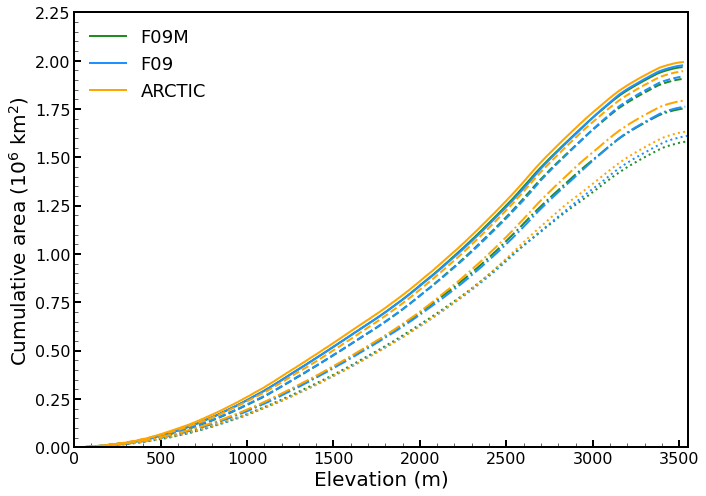

In [20]:
fig = plt.figure(figsize = (11,8))
gs=GridSpec(8,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2

#----------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0:8,0:11])

ax1.plot(f09_elev_PI.sortby(f09_elev_PI), f09_area_accum_PI.sortby(f09_area_accum_PI)/1e6, color = 'forestgreen', linewidth = line_width, label='F09M');
ax1.plot(f09_elev_stab.sortby(f09_elev_stab), f09_area_accum_stab.sortby(f09_area_accum_stab)/1e6, color = 'forestgreen', linewidth = line_width, linestyle='--');
ax1.plot(f09_elev_mid.sortby(f09_elev_mid), f09_area_accum_mid.sortby(f09_area_accum_mid)/1e6, color = 'forestgreen', linewidth = line_width, linestyle='-.');
ax1.plot(f09_elev_end.sortby(f09_elev_end), f09_area_accum_end.sortby(f09_area_accum_end)/1e6, color = 'forestgreen', linewidth = line_width, linestyle=':');

ax1.plot(f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e6, color = 'dodgerblue', linewidth = line_width, label='F09');
ax1.plot(f09_nohacks_elev_stab.sortby(f09_nohacks_elev_stab), f09_nohacks_area_accum_stab.sortby(f09_nohacks_area_accum_stab)/1e6, color = 'dodgerblue', linewidth = line_width, linestyle='--');
ax1.plot(f09_nohacks_elev_mid.sortby(f09_nohacks_elev_mid), f09_nohacks_area_accum_mid.sortby(f09_nohacks_area_accum_mid)/1e6, color = 'dodgerblue', linewidth = line_width, linestyle='-.');
ax1.plot(f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e6, color = 'dodgerblue', linewidth = line_width, linestyle=':');

ax1.plot(ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e6, color = 'orange', linewidth = line_width, label='ARCTIC');
ax1.plot(ARCTIC_elev_stab.sortby(ARCTIC_elev_stab), ARCTIC_area_accum_stab.sortby(ARCTIC_area_accum_stab)/1e6, color = 'orange', linewidth = line_width, linestyle='--');
ax1.plot(ARCTIC_elev_mid.sortby(ARCTIC_elev_mid), ARCTIC_area_accum_mid.sortby(ARCTIC_area_accum_mid)/1e6, color = 'orange', linewidth = line_width, linestyle='-.');
ax1.plot(ARCTIC_elev_end.sortby(ARCTIC_elev_end), ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e6, color = 'orange', linewidth = line_width, linestyle=':');

ax1.set_xlim([0, 3550])
ax1.set_ylim([0, 2.25])
ax1.set_xlabel('Elevation (m)', fontsize=size_label)
ax1.set_ylabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)


plt.subplots_adjust(wspace=0.3)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Elevation_area_CISM_full.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### CISM

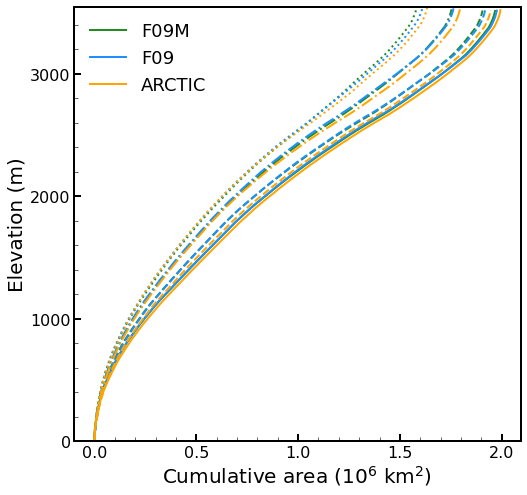

In [31]:
fig = plt.figure(figsize = (8,8))
gs=GridSpec(8,8)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
line_width = 2

#----------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0:8,0:8])

ax1.plot(f09_area_accum_PI.sortby(f09_area_accum_PI)/1e6, f09_elev_PI.sortby(f09_elev_PI), color = 'forestgreen', linewidth = line_width, label='F09M');
ax1.plot(f09_area_accum_stab.sortby(f09_area_accum_stab)/1e6, f09_elev_stab.sortby(f09_elev_stab), color = 'forestgreen', linewidth = line_width, linestyle='--');
ax1.plot(f09_area_accum_mid.sortby(f09_area_accum_mid)/1e6, f09_elev_mid.sortby(f09_elev_mid), color = 'forestgreen', linewidth = line_width, linestyle='-.');
ax1.plot(f09_area_accum_end.sortby(f09_area_accum_end)/1e6, f09_elev_end.sortby(f09_elev_end), color = 'forestgreen', linewidth = line_width, linestyle=':');

ax1.plot(f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e6, f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), color = 'dodgerblue', linewidth = line_width, label='F09');
ax1.plot(f09_nohacks_area_accum_stab.sortby(f09_nohacks_area_accum_stab)/1e6, f09_nohacks_elev_stab.sortby(f09_nohacks_elev_stab), color = 'dodgerblue', linewidth = line_width, linestyle='--');
ax1.plot(f09_nohacks_area_accum_mid.sortby(f09_nohacks_area_accum_mid)/1e6, f09_nohacks_elev_mid.sortby(f09_nohacks_elev_mid), color = 'dodgerblue', linewidth = line_width, linestyle='-.');
ax1.plot(f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e6, f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), color = 'dodgerblue', linewidth = line_width, linestyle=':');

ax1.plot(ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e6, ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), color = 'orange', linewidth = line_width, label='ARCTIC');
ax1.plot(ARCTIC_area_accum_stab.sortby(ARCTIC_area_accum_stab)/1e6, ARCTIC_elev_stab.sortby(ARCTIC_elev_stab), color = 'orange', linewidth = line_width, linestyle='--');
ax1.plot(ARCTIC_area_accum_mid.sortby(ARCTIC_area_accum_mid)/1e6, ARCTIC_elev_mid.sortby(ARCTIC_elev_mid), color = 'orange', linewidth = line_width, linestyle='-.');
ax1.plot(ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e6, ARCTIC_elev_end.sortby(ARCTIC_elev_end), color = 'orange', linewidth = line_width, linestyle=':');

#ax1.set_xlim([0, 2.25])
ax1.set_ylim([0, 3550])
ax1.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.set_ylabel('Elevation (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.set_xticks([0, 0.5, 1., 1.5, 2.])
ax1.set_yticks([0, 1000, 2000, 3000])

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)


plt.subplots_adjust(wspace=0.3)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Area_elevation_CISM_full.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### CISM+CAM

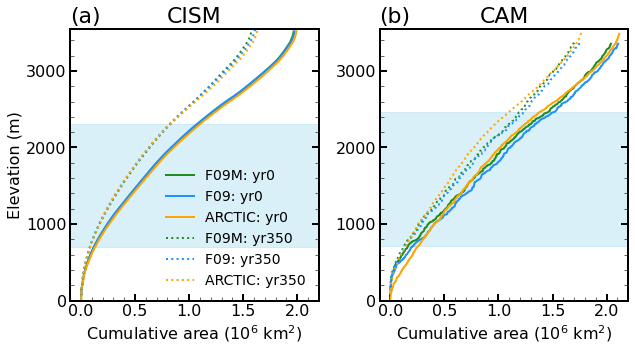

In [112]:
fig = plt.figure(figsize = (10,5))
gs=GridSpec(6,13)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 16
size_legend = 14
size_text = 18
line_width = 2

#----------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0:6,0:6])

ax1.axhspan(ARCTIC_ela_GrIS_cism_ah_sqrt_min, ARCTIC_ela_GrIS_cism_ah_sqrt_max, alpha=0.3, color='skyblue')
ax1.plot(f09_area_accum_PI_cism.sortby(f09_area_accum_PI_cism)/1e6, f09_elev_PI_cism.sortby(f09_elev_PI_cism), color = 'forestgreen', linewidth = line_width, label='F09M: yr0');
ax1.plot(f09_nohacks_area_accum_PI_cism.sortby(f09_nohacks_area_accum_PI_cism)/1e6, f09_nohacks_elev_PI_cism.sortby(f09_nohacks_elev_PI_cism), color = 'dodgerblue', linewidth = line_width, label='F09: yr0');
ax1.plot(ARCTIC_area_accum_PI_cism.sortby(ARCTIC_area_accum_PI_cism)/1e6, ARCTIC_elev_PI_cism.sortby(ARCTIC_elev_PI_cism), color = 'orange', linewidth = line_width, label='ARCTIC: yr0');

#ax1.plot(f09_area_accum_stab_cism.sortby(f09_area_accum_stab_cism)/1e6, f09_elev_stab_cism.sortby(f09_elev_stab_cism), color = 'forestgreen', linewidth = line_width, linestyle='--');
#ax1.plot(f09_area_accum_mid_cism.sortby(f09_area_accum_mid_cism)/1e6, f09_elev_mid_cism.sortby(f09_elev_mid_cism), color = 'forestgreen', linewidth = line_width, linestyle='-.');

#ax1.plot(f09_nohacks_area_accum_stab_cism.sortby(f09_nohacks_area_accum_stab_cism)/1e6, f09_nohacks_elev_stab_cism.sortby(f09_nohacks_elev_stab_cism), color = 'dodgerblue', linewidth = line_width, linestyle='--');
#ax1.plot(f09_nohacks_area_accum_mid_cism.sortby(f09_nohacks_area_accum_mid_cism)/1e6, f09_nohacks_elev_mid_cism.sortby(f09_nohacks_elev_mid_cism), color = 'dodgerblue', linewidth = line_width, linestyle='-.');

#ax1.plot(ARCTIC_area_accum_stab_cism.sortby(ARCTIC_area_accum_stab_cism)/1e6, ARCTIC_elev_stab_cism.sortby(ARCTIC_elev_stab_cism), color = 'orange', linewidth = line_width, linestyle='--');
#ax1.plot(ARCTIC_area_accum_mid_cism.sortby(ARCTIC_area_accum_mid_cism)/1e6, ARCTIC_elev_mid_cism.sortby(ARCTIC_elev_mid_cism), color = 'orange', linewidth = line_width, linestyle='-.');

ax1.plot(f09_area_accum_end_cism.sortby(f09_area_accum_end_cism)/1e6, f09_elev_end_cism.sortby(f09_elev_end_cism), color = 'forestgreen', linewidth = line_width, linestyle=':', label='F09M: yr350');
ax1.plot(f09_nohacks_area_accum_end_cism.sortby(f09_nohacks_area_accum_end_cism)/1e6, f09_nohacks_elev_end_cism.sortby(f09_nohacks_elev_end_cism), color = 'dodgerblue', linewidth = line_width, linestyle=':', label='F09: yr350');
ax1.plot(ARCTIC_area_accum_end_cism.sortby(ARCTIC_area_accum_end_cism)/1e6, ARCTIC_elev_end_cism.sortby(ARCTIC_elev_end_cism), color = 'orange', linewidth = line_width, linestyle=':', label='ARCTIC: yr350');

ax1.set_xlim([-0.1, 2.2])
ax1.set_ylim([0, 3550])
ax1.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.set_ylabel('Elevation (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
ax1.set_xticks([0, 0.5, 1., 1.5, 2.])
ax1.set_yticks([0, 1000, 2000, 3000])
plt.title('(a)', fontsize=22, loc='left')
plt.title('CISM', fontsize=22, loc='center')

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

#----------------------------------------------------------------------------------------
ax2 = plt.subplot(gs[0:6,7:13])

ax2.axhspan(ARCTIC_ela_GrIS_ah_sqrt_min, ARCTIC_ela_GrIS_ah_sqrt_max, alpha=0.3, color='skyblue')
ax2.plot(f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, f09_elev_PI.sortby(f09_elev_PI), color = 'forestgreen', linewidth = line_width, label='F09M');
ax2.plot(f09_area_accum_end.sortby(f09_area_accum_end)/1e12, f09_elev_end.sortby(f09_elev_end), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax2.plot(f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), color = 'dodgerblue', linewidth = line_width, label='F09');
ax2.plot(f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax2.plot(ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), color = 'orange', linewidth = line_width, label='ARCTIC');
ax2.plot(ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, ARCTIC_elev_end.sortby(ARCTIC_elev_end), color = 'orange', linewidth = line_width, linestyle=':');

ax2.set_xlim([-0.1, 2.2])
ax2.set_ylim([0, 3550])
ax2.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
#ax2.set_ylabel('Elevation (m)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
ax2.set_xticks([0, 0.5, 1., 1.5, 2.])
ax2.set_yticks([0, 1000, 2000, 3000])
plt.title('(b)', fontsize=22, loc='left')
plt.title('CAM', fontsize=22, loc='center')

plt.subplots_adjust(wspace=0.6)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Area_elevation_CISM_CAM_full.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### CISM+CAM & RMSE

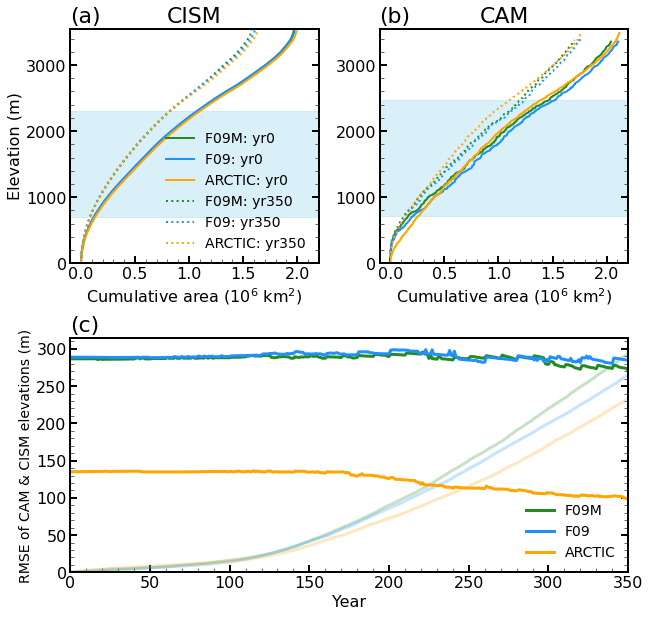

In [46]:
fig = plt.figure(figsize = (10,10))
gs=GridSpec(13,13)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 16
size_legend = 14
size_text = 18
line_width = 2

#----------------------------------------------------------------------------------------
ax1 = plt.subplot(gs[0:6,0:6])

ax1.axhspan(ARCTIC_ela_GrIS_cism_ah_sqrt_min, ARCTIC_ela_GrIS_cism_ah_sqrt_max, alpha=0.3, color='skyblue')
ax1.plot(f09_area_accum_PI_cism.sortby(f09_area_accum_PI_cism)/1e6, f09_elev_PI_cism.sortby(f09_elev_PI_cism), color = 'forestgreen', linewidth = line_width, label='F09M: yr0');
ax1.plot(f09_nohacks_area_accum_PI_cism.sortby(f09_nohacks_area_accum_PI_cism)/1e6, f09_nohacks_elev_PI_cism.sortby(f09_nohacks_elev_PI_cism), color = 'dodgerblue', linewidth = line_width, label='F09: yr0');
ax1.plot(ARCTIC_area_accum_PI_cism.sortby(ARCTIC_area_accum_PI_cism)/1e6, ARCTIC_elev_PI_cism.sortby(ARCTIC_elev_PI_cism), color = 'orange', linewidth = line_width, label='ARCTIC: yr0');

#ax1.plot(f09_area_accum_stab_cism.sortby(f09_area_accum_stab_cism)/1e6, f09_elev_stab_cism.sortby(f09_elev_stab_cism), color = 'forestgreen', linewidth = line_width, linestyle='--');
#ax1.plot(f09_area_accum_mid_cism.sortby(f09_area_accum_mid_cism)/1e6, f09_elev_mid_cism.sortby(f09_elev_mid_cism), color = 'forestgreen', linewidth = line_width, linestyle='-.');

#ax1.plot(f09_nohacks_area_accum_stab_cism.sortby(f09_nohacks_area_accum_stab_cism)/1e6, f09_nohacks_elev_stab_cism.sortby(f09_nohacks_elev_stab_cism), color = 'dodgerblue', linewidth = line_width, linestyle='--');
#ax1.plot(f09_nohacks_area_accum_mid_cism.sortby(f09_nohacks_area_accum_mid_cism)/1e6, f09_nohacks_elev_mid_cism.sortby(f09_nohacks_elev_mid_cism), color = 'dodgerblue', linewidth = line_width, linestyle='-.');

#ax1.plot(ARCTIC_area_accum_stab_cism.sortby(ARCTIC_area_accum_stab_cism)/1e6, ARCTIC_elev_stab_cism.sortby(ARCTIC_elev_stab_cism), color = 'orange', linewidth = line_width, linestyle='--');
#ax1.plot(ARCTIC_area_accum_mid_cism.sortby(ARCTIC_area_accum_mid_cism)/1e6, ARCTIC_elev_mid_cism.sortby(ARCTIC_elev_mid_cism), color = 'orange', linewidth = line_width, linestyle='-.');

ax1.plot(f09_area_accum_end_cism.sortby(f09_area_accum_end_cism)/1e6, f09_elev_end_cism.sortby(f09_elev_end_cism), color = 'forestgreen', linewidth = line_width, linestyle=':', label='F09M: yr350');
ax1.plot(f09_nohacks_area_accum_end_cism.sortby(f09_nohacks_area_accum_end_cism)/1e6, f09_nohacks_elev_end_cism.sortby(f09_nohacks_elev_end_cism), color = 'dodgerblue', linewidth = line_width, linestyle=':', label='F09: yr350');
ax1.plot(ARCTIC_area_accum_end_cism.sortby(ARCTIC_area_accum_end_cism)/1e6, ARCTIC_elev_end_cism.sortby(ARCTIC_elev_end_cism), color = 'orange', linewidth = line_width, linestyle=':', label='ARCTIC: yr350');

ax1.set_xlim([-0.1, 2.2])
ax1.set_ylim([0, 3550])
ax1.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
ax1.set_ylabel('Elevation (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax1.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax1.tick_params(labelsize=size_tick)
ax1.set_xticks([0, 0.5, 1., 1.5, 2.])
ax1.set_yticks([0, 1000, 2000, 3000])
plt.title('(a)', fontsize=22, loc='left')
plt.title('CISM', fontsize=22, loc='center')

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

#----------------------------------------------------------------------------------------
ax2 = plt.subplot(gs[0:6,7:13])

ax2.axhspan(ARCTIC_ela_GrIS_ah_sqrt_min, ARCTIC_ela_GrIS_ah_sqrt_max, alpha=0.3, color='skyblue')
ax2.plot(f09_area_accum_PI.sortby(f09_area_accum_PI)/1e12, f09_elev_PI.sortby(f09_elev_PI), color = 'forestgreen', linewidth = line_width, label='F09M');
ax2.plot(f09_area_accum_end.sortby(f09_area_accum_end)/1e12, f09_elev_end.sortby(f09_elev_end), color = 'forestgreen', linewidth = line_width, linestyle=':');
ax2.plot(f09_nohacks_area_accum_PI.sortby(f09_nohacks_area_accum_PI)/1e12, f09_nohacks_elev_PI.sortby(f09_nohacks_elev_PI), color = 'dodgerblue', linewidth = line_width, label='F09');
ax2.plot(f09_nohacks_area_accum_end.sortby(f09_nohacks_area_accum_end)/1e12, f09_nohacks_elev_end.sortby(f09_nohacks_elev_end), color = 'dodgerblue', linewidth = line_width, linestyle=':');
ax2.plot(ARCTIC_area_accum_PI.sortby(ARCTIC_area_accum_PI)/1e12, ARCTIC_elev_PI.sortby(ARCTIC_elev_PI), color = 'orange', linewidth = line_width, label='ARCTIC');
ax2.plot(ARCTIC_area_accum_end.sortby(ARCTIC_area_accum_end)/1e12, ARCTIC_elev_end.sortby(ARCTIC_elev_end), color = 'orange', linewidth = line_width, linestyle=':');

ax2.set_xlim([-0.1, 2.2])
ax2.set_ylim([0, 3550])
ax2.set_xlabel('Cumulative area ($\mathregular{10^{6}}$ $\mathregular{km^{2}}$)', fontsize=size_label)
#ax2.set_ylabel('Elevation (m)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax2.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax2.tick_params(labelsize=size_tick)
ax2.set_xticks([0, 0.5, 1., 1.5, 2.])
ax2.set_yticks([0, 1000, 2000, 3000])
plt.title('(b)', fontsize=22, loc='left')
plt.title('CAM', fontsize=22, loc='center')

#----------------------------------------------------------------------------------------
ax3 = plt.subplot(gs[7:13,:])

ax3.plot(np.arange(1,351), F09M_stopg_change_masked_RMSE, color='forestgreen', linewidth=3, alpha=0.25);
ax3.plot(np.arange(1,351), F09_stopg_change_masked_RMSE, color='dodgerblue', linewidth=3, alpha=0.25);
ax3.plot(np.arange(1,351), ARCTIC_stopg_change_masked_RMSE, color='orange', linewidth=3, alpha=0.25);

ax3.plot(np.arange(1,351), F09M_stopg_diff_masked_RMSE, color='forestgreen', linewidth=3, label='F09M');
ax3.plot(np.arange(1,351), F09_stopg_diff_masked_RMSE, color='dodgerblue', linewidth=3, label='F09');
ax3.plot(np.arange(1,351), ARCTIC_stopg_diff_masked_RMSE, color='orange', linewidth=3, label='ARCTIC');

ax3.set_xlim([0, 350])
ax3.set_ylim([0, 315])
ax3.set_xlabel('Year', fontsize=size_label)
ax3.set_ylabel('RMSE of CAM & CISM elevations (m)', fontsize=size_label-2)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in', right=True, labelright=False)
ax3.tick_params(which='minor', length=4, direction='in', right=True, labelright=False)
ax3.tick_params(labelsize=size_tick)
plt.title('(c)', fontsize=22, loc='left')

ax3.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

plt.subplots_adjust(wspace=0.6, hspace=2.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Area_elevation_CISM_CAM_full_RMSE.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)